<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Tutorial: Implementation of Single and Piecewise Polytropic EOSs

## Author: Leo Werneck
### Formatting improvements courtesy Brandon Clark

## This notebook sets up functions to compute polytropic EOSs related quantities.

**Notebook Status:** <font color='green'><b> Validated </b></font>

**Validation Notes:** The functions from this notebook have been validated by being used to produce initial data that is shown to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see [start-to-finish TOV notebook](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb) for full test). Note that convergence at the surface of the star is lower order due to the sharp drop to zero in $T^{\mu\nu}$. We have also validated many results against other TOV solvers, namely one by [Joshua Faber](https://ccrg.rit.edu/~jfaber/BNSID/TOV/tov_solver.C) and one by [Joonas Nättilä](https://github.com/natj/tov). We have also reproduced portions of figure 3 in [Demorest *et al.* (2010)](https://www.nature.com/articles/nature09466) ([go to plot](#code_validation__mass_vs_radius)).

### NRPy+ Source Code for this notebook: [TOV/Polytropic_EOSs.py](../edit/TOV/Polytropic_EOSs.py)

[comment]: <> (Introduction: TODO)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows:

0. [Step 0](#initializenrpy): **Initialize core Python/NRPy+ modules**
1. [Step 1](#introduction): **Introduction**
1. [Step 2](#continuity_of_pcold): **Continuity of $P_{\rm cold}$**
1. [Step 3](#p_poly_tab): **Computing $P_{j}$**
1. [Step 4](#continuity_of_eps_cold): **Continuity of $\epsilon_{\rm cold}$**
1. [Step 5](#eos_parameters_from_input): **Setting up EOS parameters from user input**
    1. [Step 5.a](#eos_parameters_from_input__complete_input): *Complete set of input variables*
    1. [Step 5.b](#eos_parameters_from_input__read_et_al_input): *"Read et al." set of input variables*
1. [Step 6](#pcold_from_rhob): **Computing $P_{\rm cold}\left(\rho_{b}\right)$**
1. [Step 7](#rhob_and_eps_cold_from_pcold): **Computing $\rho_{b}\left(P_{\rm cold}\right)$ and $\epsilon_{\rm cold}\left(\rho_{b},P_{\rm cold}\right)$**
1. [Step 8](#polytropic_index): **Determining the polytropic index**
    1. [Step 8.a](#polytropic_index__from_rhob): *From $\rho_{b}$*
    1. [Step 8.b](#polytropic_index__from_pcold): *From $P_{\rm cold}$*
1. [Step 9](#illinoisgrmhd_parameter_file): **Generating an EOS parameter file for `IllinoisGRMHD`**
1. [Step 10](#pcold_plot): **Visualizing $P_{\rm cold}\left(\rho_{b}\right)$**
    1. [Step 10.a](#pcold_plot__neoseq4): *Complete input set, $n_{\rm eos} = 4$ piecewise polytropic EOS*
    1. [Step 10.b](#pcold_plot__neoseq7): *"Read et al." input set, $n_{\rm eos} = 7$ piecewise polytropic EOS*
1. [Step 11](#code_validation): **Code Validation**
    1. [Step 11.a](#code_validation__self): *Against the [TOV/Polytropic_EOSs.py](../edit/TOV/Polytropic_EOSs.py) NRPy+ module*
    1. [Step 11.b](#code_validation__read_et_al): *Against [Read et al. (2008)](https://arxiv.org/pdf/0812.2163.pdf)*
    1. [Step 11.c](#code_validation__joshua_faber_tov_solver): *Against [Joshua Faber's TOV solver](https://ccrg.rit.edu/~jfaber/BNSID/TOV/tov_solver.C)*
        1. [Step 11.c.i](#code_validation__joshua_faber_tov_solver__results): Results from [Joshua Faber's TOV solver](https://ccrg.rit.edu/~jfaber/BNSID/TOV/tov_solver.C)
        1. [Step 11.c.ii](#code_validation__joshua_faber_tov_solver__restoring_units): Restoring units to the solution of NRPy+'s TOV solver
        1. [Step 11.c.iii](#code_validation__joshua_faber_tov_solver__validation): Validation of NRPy+'s results
    1. [Step 11.d](#code_validation__mass_vs_radius): *Mass vs. Radius relations*
1. [Step 12](#latex_pdf_output): **Output this module to $\LaTeX$-formatted PDF**

<a id='initializenrpy'></a>

# Step 0: Initialize core Python/NRPy+ modules \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

In [1]:
import os
nrpy_module_file_path = os.path.join("TOV","Polytropic_EOSs.py")
validation_file_path  = os.path.join("TOV","Polytropic_EOSs_validation.py")

In [2]:
%%writefile $validation_file_path
## Polytropic EOSs Python Module
## Author(s): Leo Werneck and Zach Etienne
## In this NRPy+ module we set up useful "lowlevel" functions that compute
## useful polytropic quantities.

# Full documentation for this module may be found in the NRPy+ tutorial Jupyter notebook:
#  Tutorial-TOV-Piecewise_Polytrope_EOSs.ipynb

# Step 0: Import needed Python/NRPy+ modules
import numpy as np                  # This module is used for math functions
import sys                          # This module is used for system related function calls
from collections import namedtuple  # This module is used to create named tuples

Writing TOV/Polytropic_EOSs_validation.py


<a id='introduction'></a>

# Step 1: Introduction \[Back to [top](#toc)\]
$$\label{introduction}$$

In this tutorial notebook we set up many useful lowlevel functions related to polytropic EOSs. These range from functions used to compute basic EOS quantities such as the pressure as a function of baryonic density, $P_{\rm cold}\left(\rho_{b}\right)$, the baryonic density as a function of pressure, $\rho_{b}\left(P_{\rm cold}\right)$, and the specific internal energy as a function of energy density, $\epsilon_{\rm cold}\left(\rho_{b}\right)$, to functions that are used to generate parameter files to be used by `IllinoisGRMHD`.

We have taken special care to document the derivations of the expressions that are ultimately implemented. We have also validated our functions to great extent, first performing a self validation against the [Polytropic_EOSs NRPy+ notebook](#../edit/TOV/Polytropic_EOSs.py) and then validating against multiple external sources (see [Step 11](#code_validation) for more details).

We also recommend the readers to look at [NRPy's TOV solver](#../edit/TOV/TOV_solver.py) \[[**tutorial**](Tutorial-ADM_Initial_Data-TOV.ipynb)\] and the [start-to-finish TOV initial data tutorial notebook](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb), where we demonstrate that the initial data generated using the functions in this tutorial notebook exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution.

<a id='continuity_of_pcold'></a>

# Step 2: Continuity of $P_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{continuity_of_pcold}$$

Consider a piecewise polytrope EOS of the form

$$
\boxed{
P_{\rm cold} =
\left\{
\begin{matrix}
K_{0}\rho_{b}^{\Gamma_{0}} & , & \rho_{b} \leq \rho_{0}\\
K_{1}\rho_{b}^{\Gamma_{1}} & , & \rho_{0} \leq \rho_{b} \leq \rho_{1}\\
\vdots &  & \vdots\\
K_{j}\rho_{b}^{\Gamma_{j}} & , & \rho_{j-1} \leq \rho_{b} \leq \rho_{j}\\
\vdots &  & \vdots\\
K_{N-2}\rho_{b}^{\Gamma_{N-2}} & , & \rho_{N-3} \leq \rho_{b} \leq \rho_{N-2}\\
K_{N-1}\rho_{b}^{\Gamma_{N-1}} & , & \rho_{b} \geq \rho_{N-2}
\end{matrix}
\right.
}\ .
$$

The case of a single polytrope is given by the first EOS above, with no condition imposed on the value of $\rho$, i.e.

$$
\boxed{P_{\rm cold} = K_{0}\rho_{b}^{\Gamma_{0}} = K\rho_{b}^{\Gamma}}\ .
$$

Notice that we have the following sets of variables:

$$
\left\{\underbrace{\rho_{0},\rho_{1},\ldots,\rho_{N-2}}_{N-1\ {\rm values}}\right\}\ ;\
\left\{\underbrace{K_{0},K_{1},\ldots,K_{N-1}}_{N\ {\rm values}}\right\}\ ;\
\left\{\underbrace{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N-1}}_{N\ {\rm values}}\right\}\ .
$$

Also, notice that $K_{0}$ and the entire sets $\left\{\rho_{0},\rho_{1},\ldots,\rho_{N-1}\right\}$ and $\left\{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N}\right\}$ must be specified by the user. The values of $\left\{K_{1},\ldots,K_{N}\right\}$, on the other hand, are determined by imposing that $P_{\rm cold}$ be continuous, i.e.

$$
P_{\rm cold}\left(\rho_{0}\right) = K_{0}\rho_{0}^{\Gamma_{0}} = K_{1}\rho_{0}^{\Gamma_{1}} \implies
\boxed{K_{1} = K_{0}\rho_{0}^{\Gamma_{0}-\Gamma_{1}}}\ .
$$

Analogously,

$$
\boxed{K_{j} = K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-\Gamma_{j}}\ ,\ j\in\left[1,N-1\right]}\ .
$$

Again, for the case of a single polytropic EOS, the set $\left\{\rho_{j}\right\}$ is empty and $\left\{\Gamma_{j},K_{j}\right\}\to \left\{\Gamma,K\right\}$.

Below we implement a function to set up $\left\{K_{j}\right\}$ for both single and piecewise polytropic EOSs, based on the last boxed equation above.

In [3]:
%%writefile -a $validation_file_path


# Function     : impose_continuity_on_P_cold()
# Author(s)    : Leo Werneck
# Description  : This function populates the array K_poly_tab
#                by demanding that P_cold be everywhere continuous
# Dependencies : none
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - uninitialized, see output variable below
#                  P_poly_tab     - uninitialized, see function
#                                   compute_P_poly_tab() below
#                K_poly_tab0      - value of K_poly_tab[0], for the first EOS
#
# Outputs      : eos.K_poly_tab   - values of K to be used within each EOS, determined
#                                   by imposing that P_cold be everywhere continuous

def impose_continuity_on_P_cold(eos,K_poly_tab0):
    
    # A piecewise polytropic EOS is given by
    # .--------------------------------------------------------------------------.
    # |      /     K_0 * rho^(Gamma_0)     ,                rho < rho_0 ;        |
    # |      |     K_1 * rho^(Gamma_1)     ,        rho_0 < rho < rho_1 ;        |
    # |      |          ...                                 ...                  |
    # | P = <      K_j * rho^(Gamma_j)     ,    rho_(j-1) < rho < rho_j ;        |
    # |      |          ...                                 ...                  |
    # |      | K_(n-2) * rho^(Gamma_(n-2)) , rho_(neos-3) < rho < rho_(neos-2) ; |
    # |      \ K_(n-1) * rho^(Gamma_(n-1)) ,                rho > rho_(neos-2) . |
    # .--------------------------------------------------------------------------.
    # Notice that the case of a single polytropic EOS corresponds to
    # the first EOS in the boxed equation above, with no condition on
    # rho. Thus we need only return K_poly_tab0.
    eos.K_poly_tab[0] = K_poly_tab0
    if eos.neos==1:
        return
    
    # For the case of a piecewise polytropic EOS, emanding that P_cold
    # be everywhere continuous results in the relation:
    # .-----------------------------------------------------.
    # | K_j = K_(j-1) * rho_(j-1)^( Gamma_(j-1) - Gamma_j ) |
    # .-----------------------------------------------------.
    for j in range(1,eos.neos):
        eos.K_poly_tab[j] = eos.K_poly_tab[j-1]*eos.rho_poly_tab[j-1]**(eos.Gamma_poly_tab[j-1]-eos.Gamma_poly_tab[j])
        
    return

Appending to TOV/Polytropic_EOSs_validation.py


<a id='p_poly_tab'></a>

# Step 3: Computing $P_{j}$ \[Back to [top](#toc)\]
$$\label{p_poly_tab}$$

We now set a new set of quantities, $P_{\rm tab}$, which are used in a similar fashion to $\rho_{j}$, that is, to determine which EOS we should use. This quantity is defined as:

$$
\boxed{
P_{\rm tab} =
\left\{
\begin{matrix}
P_{0} = K_{0}\rho_{0}^{\Gamma_{0}}& , & P \leq P_{0} \implies \rho_{b} \leq \rho_{0}\\
P_{1} = K_{1}\rho_{1}^{\Gamma_{1}}& , & P_{0}\leq P\leq P_{1} \implies \rho_{0} \leq \rho_{b} \leq \rho_{1}\\
\vdots & & \vdots\\
P_{j} = K_{j}\rho_{j}^{\Gamma_{j}}& , & P_{j-1}\leq P\leq P_{j} \implies \rho_{j-1} \leq \rho_{b} \leq \rho_{j}\\
\vdots & & \vdots\\
P_{N-2} = K_{N-2}\rho_{N-2}^{\Gamma_{N-2}}& , & P_{N-3}\leq P\leq P_{N-2} \implies \rho_{N-3} \leq \rho_{b} \leq \rho_{N-2}\\
- & , & P \geq P_{N-2} \implies \rho_{b} \geq \rho_{N-2}\ .
\end{matrix}
\right.
}
$$

In [4]:
%%writefile -a $validation_file_path


# Function     : compute_P_poly_tab()
# Author(s)    : Leo Werneck
# Description  : This function populates the array eos.P_poly_tab,
#                used to distinguish which EOS we are using in the
#                case of a piecewise polytropic EOS
# Dependencies : none
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - uninitialized, see output variable below
#
# Outputs      : eos.P_poly_tab   - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)

def compute_P_poly_tab(eos):
    
    # We now compute the values of P_poly_tab that are used
    # to find the appropriate polytropic index and, thus,
    # EOS we must use.
    # First, if we have a single polytrope EOS, we need to
    # do nothing.
    if eos.neos==1:
        return
    
    # For the case of a piecewise polytropic EOS, we have
    # .---------------------------.
    # | P_j = K_j*rho_j^(Gamma_j) |
    # .---------------------------.
    for j in range(eos.neos-1):
        eos.P_poly_tab[j] = eos.K_poly_tab[j]*eos.rho_poly_tab[j]**(eos.Gamma_poly_tab[j])
        
    return

Appending to TOV/Polytropic_EOSs_validation.py


<a id='continuity_of_eps_cold'></a>

# Step 4: Continuity of $\epsilon_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{continuity_of_eps_cold}$$

$\epsilon_{\rm cold}$ is determined via

$$
\epsilon_{\rm cold} = \int d\rho\, \frac{P_{\rm cold}}{\rho^{2}} \ ,
$$

for some integration constant $C$. **Notation alert**: in the literature, the integration constants $C_{j}$ below are usually called $\epsilon_{j}$. We will keep them as $C_{j}$ for a clearer exposition.

In the case of a piecewise polytropic EOS, we then must have

$$
\boxed{
\epsilon_{\rm cold} = 
\left\{
\begin{matrix}
\frac{K_{0}\rho^{\Gamma_{0}-1}}{\Gamma_{0}-1} + C_{0} & , & \rho \leq \rho_{0}\\
\frac{K_{1}\rho^{\Gamma_{1}-1}}{\Gamma_{1}-1} + C_{1} & , & \rho_{0} \leq \rho \leq \rho_{1}\\
\vdots &  & \vdots\\
\frac{K_{j}\rho^{\Gamma_{j}-1}}{\Gamma_{j}-1} + C_{j} & , & \rho_{j-1} \leq \rho \leq \rho_{j}\\
\vdots &  & \vdots\\
\frac{K_{N-2}\rho^{\Gamma_{N-2}-1}}{\Gamma_{N-2}-1} + C_{N-2} & , & \rho_{N-3} \leq \rho \leq \rho_{N-2}\\
\frac{K_{N-1}\rho^{\Gamma_{N-1}-1}}{\Gamma_{N-1}-1} + C_{N-1} & , & \rho \geq \rho_{N-2}
\end{matrix}
\right.
}\ .
$$

We fix $C_{0}$ by demanding that $\epsilon_{\rm cold}\left(\rho=0\right) = 0$. Then, continuity of $\epsilon_{\rm cold}$ imposes that

$$
\frac{K_{0}\rho_{0}^{\Gamma_{0}-1}}{\Gamma_{0}-1} = \frac{K_{1}\rho_{0}^{\Gamma_{1}-1}}{\Gamma_{1}-1} + C_{1}\implies \boxed{C_{1} = \frac{K_{0}\rho_{0}^{\Gamma_{0}-1}}{\Gamma_{0}-1} - \frac{K_{1}\rho_{0}^{\Gamma_{1}-1}}{\Gamma_{1}-1}}\ ,
$$

for $C_{1}$ and

$$
\boxed{C_{j} = C_{j-1} + \frac{K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-1}}{\Gamma_{j-1}-1} - \frac{K_{j}\rho_{j-1}^{\Gamma_{j}-1}}{\Gamma_{j}-1}\ ,\ j\geq1}\ ,
$$

generically. Below we implement a function to set up $\left\{C_{j}\right\}$ for both single and piecewise polytropic EOSs, based on the last boxed equation above.

In [5]:
%%writefile -a $validation_file_path


# Function     : impose_continuity_on_eps_cold()
# Author(s)    : Leo Werneck
# Description  : This function populates the array eps_integ_const_tab
#                by demanding that eps_cold be everywhere continuous
# Dependencies : none
#
# Inputs       : eos                     - named tuple containing the following:
#                  neos                  - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab          - values of rho distinguish one EOS from the
#                                          other (not required for a single polytrope)
#                  Gamma_poly_tab        - values of Gamma to be used within each EOS
#                  K_poly_tab            - value of K to be used within each EOS
#                  eps_integ_const_tab   - uninitialized, see output variable below
#
# Outputs      : eos.eps_integ_const_tab - value of C used to compute eps_cold within each EOS,
#                                          determined by imposing that eps_cold be everywhere 
#                                          continuous

def impose_continuity_on_eps_cold(eos):
    
    # Computing eps_cold for the case of a polytropic EOS, we have
    # .------------------------------------------------------------------------------------------------------.
    # |        / C_0     + K_0*rho^(Gamma_0 - 1)/(Gamma_0 - 1)         ,                rho < rho_0 ;        |
    # |        | C_1     + K_1*rho^(Gamma_1 - 1)/(Gamma_1 - 1)         ,        rho_0 < rho < rho_1 ;        |
    # |        |                       ...                                              ...                  |
    # | eps = <  C_j     + K_j*rho^(Gamma_j - 1)/(Gamma_j - 1)         ,    rho_(j-1) < rho < rho_j ;        |
    # |        |                       ...                                              ...                  |
    # |        | C_(n-2) + K_(n-2)*rho^(Gamma_(n-2)-1)/(Gamma_(n-2)-1) , rho_(neos-3) < rho < rho_(neos-2) ; |
    # |        \ C_(n-1) + K_(n-1)*rho^(Gamma_(n-1)-1)/(Gamma_(n-1)-1) ,                rho > rho_(neos-2) . |
    # .------------------------------------------------------------------------------------------------------.
    # By demanding that eps_cold(rho -> 0) = 0, we fix C_0 = 0. Thus, for
    # a single polytrope we need only return this
    if eos.neos==1:
        return
    
    # For the case of a piecewise polytropic EOS, emanding that eps_cold
    # be everywhere continuous results in the relation:
    # .-----------------------------------------------------------------.
    # | C_j = C_(j-1)                                                   |
    # |     + K_(j-1)*rho_(j-1)^( Gamma_(j-1) - 1 )/( Gamma_(j-1) - 1 ) |
    # |     - K_(j+0)*rho_(j-1)^( Gamma_(j+0) - 1 )/( Gamma_(j+0) - 1 ) |
    # .-----------------------------------------------------------------.
    eos.eps_integ_const_tab[0] = 0.0
    for j in range(1,eos.neos):
        # Second line of the boxed equation above
        aux_jm1 = eos.K_poly_tab[j-1]*eos.rho_poly_tab[j-1]**(eos.Gamma_poly_tab[j-1]-1.0)/(eos.Gamma_poly_tab[j-1]-1)
        
        # Third line of the boxed equation above
        aux_jp0 = eos.K_poly_tab[j+0]*eos.rho_poly_tab[j-1]**(eos.Gamma_poly_tab[j+0]-1.0)/(eos.Gamma_poly_tab[j+0]-1)
        
        # Boxed equation above
        eos.eps_integ_const_tab[j] = eos.eps_integ_const_tab[j-1] + aux_jm1 - aux_jp0
        
    return

Appending to TOV/Polytropic_EOSs_validation.py


<a id='eos_parameters_from_input'></a>

# Step 5: Setting up EOS parameters from user input \[Back to [top](#toc)\]
$$\label{eos_parameters_from_input}$$

<a id='eos_parameters_from_input__complete_input'></a>

## Step 5.a: Complete set of input variables \[Back to [top](#toc)\]
$$\label{eos_parameters_from_input__complete_input}$$

We now implement a driver function to set up all polytropic EOS related quantities based on the input given by the user. From the given input set:

$$
\left\{n_{\rm eos}, \rho_{j}, \Gamma_{j}, K_{0}\right\}\ ,
$$

the code returns a "C like struct" (a [*named tuple*](https://docs.python.org/3/library/collections.html#collections.namedtuple)) containing

$$
\left\{n_{\rm eos}, \rho_{j}, \Gamma_{j}, K_{j}, P_{j}\right\}\ .
$$

In [6]:
%%writefile -a $validation_file_path


# Function     : set_up_EOS_parameters__complete_set_of_input_variables()
# Author(s)    : Leo Werneck
# Description  : This function determine all polytropic related
#                parameters from user input
# Dependencies : impose_continuity_on_P_cold()
#                compute_P_poly_tab()
#
# Inputs       : neos             - number of EOSs to be used (single polytrope = 1)
#                rho_poly_tab     - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                Gamma_poly_tab   - values of Gamma to be used within each EOS
#                K_poly_tab0      - value of K_poly_tab[0], for the first EOS
#
# Outputs      : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)

def set_up_EOS_parameters__complete_set_of_input_variables(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0):

    # Error check #1: Verify if the correct number of rho_poly_tab has been given by the user
    if (neos == 1):
        pass
    elif len(rho_poly_tab) != neos-1:
        print("Error: neos="+str(neos)+". Expected "+str(neos-1)+" values of rho_poly_tab, but "+str(len(rho_poly_tab))+" values were given.")
        sys.exit(1)

    # Error check #2: Verify if the correct number of Gamma_poly_tab has been given by the user
    if len(Gamma_poly_tab) != neos:
        print("Error: neos="+str(neos)+". Expected "+str(neos)+" values of Gamma_poly_tab, but "+str(len(Gamma_poly_tab))+" values were given.")
        sys.exit(2)

    # Create the arrays to store the values of K_poly_tab and eps_integ_const_tab
    K_poly_tab          = [0 for i in range(neos)]
    P_poly_tab          = [0 for i in range(neos-1)]
    eps_integ_const_tab = [0 for i in range(neos)]
    
    # Create the EOS "struct" (named tuple)
    eos_struct = namedtuple("eos_struct","neos rho_poly_tab Gamma_poly_tab K_poly_tab P_poly_tab eps_integ_const_tab")
    eos = eos_struct(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab,P_poly_tab,eps_integ_const_tab)
    
    # Step 1: Determine K_poly_tab. For the details, please see the implementation
    #         of the function impose_continuity_on_P_cold() below.
    impose_continuity_on_P_cold(eos,K_poly_tab0)
    
    # Step 2: Determine eps_integ_const_tab. For the details, please see the
    #         implementation of the function impose_continuity_on_eps_cold() below.
    impose_continuity_on_eps_cold(eos)
    
    # Step 3: Determine P_poly_tab. For the details, please see the implementation
    #         of the function compute_P_poly_tab() below.
    compute_P_poly_tab(eos)
    
    return eos

Appending to TOV/Polytropic_EOSs_validation.py


<a id='eos_parameters_from_input__read_et_al_input'></a>

## Step 5.b: "Read *et al.*" set of input variables \[Back to [top](#toc)\]
$$\label{eos_parameters_from_input__read_et_al_input}$$

We now implement a driver function to set up all polytropic EOS related quantities based on the input given by the user that follows tables II and III in [Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf). The input structure is the following:

|  $\rho_{j}$  | $\Gamma_{j}$ |   $K_{j}$   |
|--------------|--------------|-------------|
| 2.440340e+07 |   1.58425    | 6.80110e-09 |
| 3.78358e+11  |   1.28733    |     $-$     |
| 2.62780e+12  |   0.62223    |     $-$     |
|  $\rho_{3}$  |   1.35692    |     $-$     |
| $10^{14.7}$  | $\Gamma_{4}$ |     $-$     |
| $10^{15.0}$  | $\Gamma_{5}$ |     $-$     |
|     $-$      | $\Gamma_{6}$ |     $-$     |

The values $\left\{\rho_{0},\rho_{1},\rho_{2},\Gamma_{0},\Gamma_{1},\Gamma_{2},\Gamma_{3},K_{0}\right\}$ are taken from table II in [Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf) and are fixed input values. The user then needs to input $\left\{\log_{10}\left(P_{4}\right),\Gamma_{4},\Gamma_{5},\Gamma_{6}\right\}$, where

$$
P_{4} \equiv K_{4}\rho_{4}^{\Gamma_{4}}\ ,
$$

is, in our code's notation, the value of ${\rm P\_poly\_tab[4]}$. There is a unit conversion that must be performed:

$$
\log_{10}\left(P_{4}\right)\to\log_{10}\left(P_{4}\right)-2\log_{10}\left(c\right)\ ,
$$

before exponentiating the input variable to obtain $P_{4}$. After that, we must determine $\rho_{3}$, and we now describe the equation we use to do so. Consider the EOS for $P_{4}$ above and use the continuity condition:

$$
K_{4} = K_{3}\rho_{3}^{\Gamma_{3}-\Gamma_{4}}\ ,
$$

which yields

$$
P_{4} = \left(K_{3}\rho_{3}^{\Gamma_{3}-\Gamma_{4}}\right)\rho_{4}^{\Gamma_{4}}\implies \boxed{\rho_{3} = \left[\frac{P_{4}}{K_{3}\rho_{4}^{\Gamma_{4}}}\right]^{\frac{1}{\Gamma_{3}-\Gamma_{4}}}}\ .
$$

Once we have determined all the EOS quantities, we then convert them to geometrized units, where $G=1=c$. We also set

$$
\boxed{\rho_{\rm nuclear} \equiv 1\times10^{15} \to 1}\ .
$$

Imposing a ratio-preserving rescaling of the baryonic density, we then have

$$
\frac{\rho_{j}}{\rho_{j-1}} = \frac{\rho^{\rm rescaled}_{j}}{\rho^{\rm rescaled}_{j-1}} \implies
\boxed{\rho^{\rm rescaled}_{j-1} = \left(\frac{\rho_{j-1}}{\rho_{j}}\right)\rho^{\rm rescaled}_{j}}\ .
$$

Because we have $P_{\rm cold}$ set in the same units as $\rho_{b}$, then the ratio-preserving rescaling must also apply to it

$$
\boxed{P^{\rm rescaled}_{j-1} = \left(\frac{\rho_{j-1}}{\rho_{j}}\right)P^{\rm rescaled}_{j}}\ ,
$$

which then allows us to determine the new values of $K_{j}$ via the standard EOS identity

$$
\boxed{ K^{\rm rescaled}_{j} = \frac{P^{\rm rescaled}_{j}}{\left(\rho^{\rm rescaled}_{j}\right)^{\Gamma_{j}}} }\ .
$$

In [7]:
%%writefile -a $validation_file_path


# Function     : set_up_EOS_parameters__Read_et_al_input_variables()
# Author(s)    : Leo Werneck
# Description  : This function determine all polytropic related
#                parameters from user input
# Dependencies : impose_continuity_on_P_cold()
#                compute_P_poly_tab()
#
# Inputs       : neos             - number of EOSs to be used (single polytrope = 1)
#                rho_poly_tab     - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                Gamma_poly_tab   - values of Gamma to be used within each EOS
#                K_poly_tab0      - value of K_poly_tab[0], for the first EOS
#
# Outputs      : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)

def set_up_EOS_parameters__Read_et_al_input_variables(EOSname):

    # Set up the number of polytropic EOSs, which is
    # fixed at seven for this type of input
    neos = 7
    
    # Set up input from table II of Read et al. (2008),
    # and from the legend in FIG. 3.
    # Source: https://arxiv.org/pdf/0812.2163.pdf
    # .--------------.---------.-------------.-----.
    # |    rho_j     | Gamma_j |     K_j     | P_j |
    # .--------------.---------.-------------.-----.
    # | 2.440340e+07 | 1.58425 | 6.80110e-09 | P_0 |
    # | 3.78358e+11  | 1.28733 |     K_1     | P_1 |
    # | 2.62780e+12  | 0.62223 |     K_2     | P_2 |
    # |    rho_3     | 1.35692 |     K_3     | P_3 |
    # |  10^(14.7)   | Gamma_4 |     K_4     | P_4 |
    # |  10^(15.0)   | Gamma_5 |     K_5     | P_5 |
    # |       -      | Gamma_6 |     K_6     |  -  |
    # .--------------.---------.-------------.-----.
    #
    # Load up the NRPy+ dictionary containing information about the Read et al.
    # EOS tables (table III in Read et al. - https://arxiv.org/pdf/0812.2163.pdf)
    import TOV.Piecewise_Polytrope__dict as PPdict
    log_of_p4 = PPdict.EOS_Read_et_al_dict[EOSname].log_of_p4
    Gamma4    = PPdict.EOS_Read_et_al_dict[EOSname].Gamma4
    Gamma5    = PPdict.EOS_Read_et_al_dict[EOSname].Gamma5
    Gamma6    = PPdict.EOS_Read_et_al_dict[EOSname].Gamma6
    
    # Set up the speed of light and change the units of the input pressure
    c = 2.9979e10 # cm/s -- cgs units
    log_of_p4 -= 2.0*np.log10(c)
    
    # Set up tabulated polytropic values following the table above
    # and the user input. All quantities which are still unknown are
    # set to absurd values to make sure they are overwritten
    rho_poly_tab   = [2.440340e+07, 3.78358e+11, 2.62780e+12, -1e30  , 10**(14.7)     , 10**(15.0)]
    P_poly_tab     = [-1e30       , -1e30      , -1e30      , -1e30  , 10**(log_of_p4), -1e30     ]
    Gamma_poly_tab = [1.58425     , 1.28733    , 0.62223    , 1.35692, Gamma4         , Gamma5, Gamma6]
    K_poly_tab     = [6.80110e-09 , -1e30      , -1e30      , -1e30  , -1e30          , -1e30  , -1e30]
    
    # Compute {K_1,K_2,K_3}, using
    # .-----------------------------------------------------.
    # | K_j = K_(j-1) * rho_(j-1)^( Gamma_(j-1) - Gamma_j ) |
    # .-----------------------------------------------------.
    for j in range(1,4):
        K_poly_tab[j] = K_poly_tab[j-1] * rho_poly_tab[j-1]**(Gamma_poly_tab[j-1] - Gamma_poly_tab[j])
    
    # Compute {P_0,P_1,P_2}, using
    # .-------------------------------.
    # | P_j = K_j * rho_j^( Gamma_j ) |
    # .-------------------------------.
    for j in range(3):
        P_poly_tab[j] = K_poly_tab[j] * rho_poly_tab[j]**(Gamma_poly_tab[j])
        
        
    # Set up auxiliary variables for the evaluation of rho_3
    P4          = P_poly_tab[4]
    K3          = K_poly_tab[3]
    rho4_p_Gam4 = rho_poly_tab[4]**(Gamma_poly_tab[4])
    G3m4        = Gamma_poly_tab[3] - Gamma_poly_tab[4]
    
    # Compute rho_3 using
    # .----------------------------------------------------------------------.
    # | rho_3 = ( P_4 /( K_3 * rho_4^(Gamma_4) ) )^(1.0/(Gamma_3 - Gamma_4)) |
    # .----------------------------------------------------------------------.
    rho_poly_tab[3] = ( P4/(K3 * rho4_p_Gam4) )**(1.0/G3m4)
    
    # Compute {P_3,P_4,P_5} and {K_4,K_5,K_6}
    for j in range(3,neos-1):
        P_poly_tab[j]   = K_poly_tab[j] * rho_poly_tab[j]**(Gamma_poly_tab[j])
        K_poly_tab[j+1] = K_poly_tab[j] * rho_poly_tab[j]**(Gamma_poly_tab[j] - Gamma_poly_tab[j+1])
     
    # We impose a "ratio preserving rescaling" of rhob:
    #
    # rhob_rescaled[j] / rhob[j] = rhob_rescaled[j-1] / rhob[j-1]
    #
    # which implies the relation
    # .-------------------------------------------------------------.
    # | rhob_rescaled[j-1] = (rhob[j-1]/rhob[j]) * rhob_rescaled[j] |
    # .-------------------------------------------------------------.
    # after setting rhob_nuclear_rescaled = 1
    rhob_rescaled  = [1.0 for i in range(neos-1)]
    for j in range(neos-2,0,-1):
        rhob_rescaled[j-1] = (rho_poly_tab[j-1]/rho_poly_tab[j]) * rhob_rescaled[j]
    
    # Now because the values of P and rho given by Read et al. are already
    # in the same units, namely (g/cm^3), the ratio P/rho should be invariant
    # under this rescalling procedure. Therefore
    # .---------------------------------------------------------------------.
    # | P_rescaled[j] = (rhob_rescaled[j]/rhob_readetal[j]) * P_readetal[j] |
    # .---------------------------------------------------------------------.
    P_rescaled = [0.0 for i in range(neos-1)]
    for j in range(neos-1):
        P_rescaled[j] = (rhob_rescaled[j]/rho_poly_tab[j]) * P_poly_tab[j]
    
    rho_poly_tab = rhob_rescaled
    P_poly_tab   = P_rescaled
    
    # Demanding that the pressure be everywhere continuous then imposes
    # .-------------------------------------------------------------------------------------------.
    # | K_dimensionless[j-1] = K_dimensionless[j]/rhob_dimensionless[j-1]^(Gamma[j-1] - Gamma[j]) |
    # .-------------------------------------------------------------------------------------------.
    K_poly_tab[0] = P_poly_tab[0]/rho_poly_tab[0]**(Gamma_poly_tab[0])
    for j in range(1,neos):
        K_poly_tab[j] = K_poly_tab[j-1]*rho_poly_tab[j-1]**(Gamma_poly_tab[j-1]-Gamma_poly_tab[j])
    
    # Allocate memory for the integration constants of eps_cold
    eps_integ_const_tab = [0 for i in range(neos)]
    
    # Create the EOS "struct" (named tuple)
    eos_struct = namedtuple("eos_struct","neos rho_poly_tab Gamma_poly_tab K_poly_tab P_poly_tab eps_integ_const_tab")
    eos = eos_struct(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab,P_poly_tab,eps_integ_const_tab)
    
    # Populate the integration constants of eps_cold
    impose_continuity_on_eps_cold(eos)
    
    return eos

Appending to TOV/Polytropic_EOSs_validation.py


<a id='pcold_from_rhob'></a>

# Step 6: Computing $P_{\rm cold}\left(\rho_{b}\right)$ \[Back to [top](#toc)\]
$$\label{pcold_from_rhob}$$

Then, let us compute $P_{\rm cold}$ for a polytropic EOS:

$$
\boxed{
P_{\rm cold} =
\left\{
\begin{matrix}
K_{0}\rho_{b}^{\Gamma_{0}} & , & \rho_{b} \leq \rho_{0}\\
K_{1}\rho_{b}^{\Gamma_{1}} & , & \rho_{0} \leq \rho_{b} \leq \rho_{1}\\
\vdots &  & \vdots\\
K_{j}\rho_{b}^{\Gamma_{j}} & , & \rho_{j-1} \leq \rho_{b} \leq \rho_{j}\\
\vdots &  & \vdots\\
K_{N-2}\rho_{b}^{\Gamma_{N-2}} & , & \rho_{N-3} \leq \rho_{b} \leq \rho_{N-2}\\
K_{N-1}\rho_{b}^{\Gamma_{N-1}} & , & \rho_{b} \geq \rho_{N-2}
\end{matrix}
\right.
}\ .
$$

In [8]:
%%writefile -a $validation_file_path


# Function     : Polytrope_EOS__compute_P_cold_from_rhob()
# Author(s)    : Leo Werneck
# Description  : This function computes P_cold for a polytropic EOS
# Dependencies : polytropic_index_from_rhob()
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                rho_baryon       - the value of rho for which we want to
#                                   compute P_cold
#
# Outputs      : P_cold           - for a single or piecewise polytropic EOS

def Polytrope_EOS__compute_P_cold_from_rhob(eos, rho_baryon):
    
    # Compute the polytropic index from rho_baryon
    j = polytropic_index_from_rhob(eos, rho_baryon)
    
    # Return the value of P_cold for a polytropic EOS
    # .--------------------------------.
    # | P_cold = K_j * rho_b^(Gamma_j) |
    # .--------------------------------.
    return eos.K_poly_tab[j]*rho_baryon**eos.Gamma_poly_tab[j]

Appending to TOV/Polytropic_EOSs_validation.py


<a id='rhob_and_eps_cold_from_pcold'></a>

# Step 7: Computing $\rho_{b}\left(P_{\rm cold}\right)$ and $\epsilon_{\rm cold}\left(\rho_{b},P_{\rm cold}\right)$ \[Back to [top](#toc)\]
$$\label{rhob_and_eps_cold_from_pcold}$$

Then, let us compute $\rho_{b}$ as a function of $P_{\rm cold}\equiv P$ for a polytropic EOS:

$$
\boxed{
\rho_{b} =
\left\{
\begin{matrix}
\left(\frac{P}{K_{0}}\right)^{1/\Gamma_{0}} & , & P \leq P_{0}\\
\left(\frac{P}{K_{1}}\right)^{1/\Gamma_{1}} & , & P_{0} \leq P \leq P_{1}\\
\vdots &  & \vdots\\
\left(\frac{P}{K_{j}}\right)^{1/\Gamma_{j}} & , & P_{j-1} \leq P \leq P_{j}\\
\vdots &  & \vdots\\
\left(\frac{P}{K_{N-2}}\right)^{1/\Gamma_{N-2}} & , & P_{N-3} \leq P \leq P_{N-2}\\
\left(\frac{P}{K_{N-1}}\right)^{1/\Gamma_{N-1}} & , & P \geq P_{N-2}
\end{matrix}
\right.
}\ .
$$

In [9]:
%%writefile -a $validation_file_path


# Function     : Polytrope_EOS__compute_rhob_from_P_cold()
# Author(s)    : Leo Werneck
# Description  : This function computes rho_b for a polytropic EOS
# Dependencies : polytropic_index_from_P()
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                P                - the value of P for which we want to
#                                   compute rho_b
#
# Outputs      : rho_baryon       - for a single or piecewise polytropic EOS

def Polytrope_EOS__compute_rhob_from_P_cold(eos,P):
    
    # Compute the polytropic index from P
    j = polytropic_index_from_P(eos,P)
    
    # Return the value of rho_b for a polytropic EOS
    # .----------------------------------.
    # | rho_b = (P_cold/K_j)^(1/Gamma_j) |
    # .----------------------------------.
    return (P/eos.K_poly_tab[j])**(1.0/eos.Gamma_poly_tab[j])

Appending to TOV/Polytropic_EOSs_validation.py


Then we compute $\epsilon_{\rm cold}$:

$$
\boxed{\epsilon_{\rm cold} = \frac{P_{\rm cold}}{\rho_{b}\left(\Gamma_{\rm poly}-1\right)}}\ .
$$

In [10]:
%%writefile -a $validation_file_path


# Function     : Polytrope_EOS__compute_eps_cold_from_rhob()
# Author(s)    : Leo Werneck
# Description  : This function computes eps_cold for a polytropic EOS
# Dependencies : polytropic_index_from_rhob()
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                rho_baryon       - the value of rho for which we want to
#                                   compute P_cold
#
# Outputs      : eps_cold         - for a single or piecewise polytropic EOS

def Polytrope_EOS__compute_eps_cold_from_rhob(eos, rho_baryon):
    
    if rho_baryon == 0.0:
        return 0.0
    
    # Compute the polytropic index from rho_baryon
    j = polytropic_index_from_rhob(eos, rho_baryon)

    # Compute P_cold
    P_cold = Polytrope_EOS__compute_P_cold_from_rhob(eos, rho_baryon)

    # Return the value of P_cold for a polytropic EOS
    # .----------------------------------------------.
    # | eps_cold = C_j + P_cold/( rhob*(Gamma_j-1) ) |
    # .----------------------------------------------.
    return ( eos.eps_integ_const_tab[j] + P_cold/(rho_baryon*(eos.Gamma_poly_tab[j] - 1.0)) )

# Function     : Polytrope_EOS__compute_rhob_and_eps_cold_from_P_cold()
# Author(s)    : Leo Werneck
# Description  : This function computes rho_b and eps_cold for a polytropic EOS
# Dependencies : polytropic_index_from_P()
#                Polytrope_EOS__compute_rhob_from_P_cold()
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                P                - the value of P for which we want to
#                                   compute rho_b
#
# Outputs      : rho_baryon       - for a single or piecewise polytropic EOS

def Polytrope_EOS__compute_rhob_and_eps_cold_from_P_cold(eos,P):
    
    # Compute the polytropic index from P and set Gamma
    j     = polytropic_index_from_P(eos,P)
    Gamma = eos.Gamma_poly_tab[j]
    # Compute the value of rho_b for a polytropic EOS
    # .----------------------------------.
    # | rho_b = (P_cold/K_j)^(1/Gamma_j) |
    # .----------------------------------.
    rho_b = (P/eos.K_poly_tab[j])**(1.0/Gamma)
    
    return rho_b, Polytrope_EOS__compute_eps_cold_from_rhob(eos, rho_b)

Appending to TOV/Polytropic_EOSs_validation.py


<a id='polytropic_index'></a>

# Step 8: Determining the polytropic index \[Back to [top](#toc)\]
$$\label{polytropic_index}$$

<a id='polytropic_index__from_rhob'></a>

## Step 8.a: From $\rho_{b}$ \[Back to [top](#toc)\]
$$\label{polytropic_index__from_rhob}$$

The function below determines the polytropic index from a given value $\rho_{b} = \rho_{\rm in}$.

In [11]:
%%writefile -a $validation_file_path


# Function     : polytropic_index_from_rhob()
# Author(s)    : Leo Werneck and Zach Etienne
# Description  : This function computes P_cold for a polytropic EOS
# Dependencies : none
#
# Input(s)     : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                rho_in           - value of rho for which we compute the
#                                   polytropic index
#
# Output(s)    : polytropic index computed from rho_in

def polytropic_index_from_rhob(eos, rho_in):
    
    # Returns the value of the polytropic index based on rho_in
    polytropic_index = 0
    if not (eos.neos==1):
        for j in range(eos.neos-1):
            polytropic_index += (rho_in > eos.rho_poly_tab[j])
            
    return polytropic_index

Appending to TOV/Polytropic_EOSs_validation.py


<a id='polytropic_index__from_pcold'></a>

## Step 8.b: From $P_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{polytropic_index__from_pcold}$$

The function below determines the polytropic index from a given value $P_{\rm cold} = P$.

In [12]:
%%writefile -a $validation_file_path


# Function     : polytropic_index_from_P()
# Author(s)    : Leo Werneck and Zach Etienne
# Description  : This function computes P_cold for a polytropic EOS
# Dependencies : none
#
# Input(s)     : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                P_in             - value of P for which we compute the
#                                   polytropic index
#
# Output(s)    : polytropic index computed from P_in

def polytropic_index_from_P(eos, P_in):
    
    # Returns the value of the polytropic index based on P_in
    polytropic_index = 0
    if not (eos.neos==1):
        for j in range(eos.neos-1):
            polytropic_index += (P_in > eos.P_poly_tab[j])
            
    return polytropic_index

Appending to TOV/Polytropic_EOSs_validation.py


<a id='illinoisgrmhd_parameter_file'></a>

# Step 9: Generating an EOS parameter file for `IllinoisGRMHD` \[Back to [top](#toc)\]
$$\label{illinoisgrmhd_parameter_file}$$

We now generate a parameter file for `IllinoisGRMHD` from the EOS parameters we have just determined.

In [13]:
%%writefile -a $validation_file_path


# Function     : generate_IllinoisGRMHD_EOS_parameter_file()
# Author(s)    : Leo Werneck and Zach Etienne
# Description  : This function computes P_cold for a polytropic EOS
# Dependencies : none
#
# Input(s)     : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
# Output(s)    : parameter file to be used by IllinoisGRMHD

def generate_IllinoisGRMHD_EOS_parameter_file(EOSname,outfilename, \
                                              Gamma_thermal=None,  \
                                              EOS_struct=None, \
                                              tau_atmosphere=4.876083025795607e-12, \
                                              rho_atmosphere=1.292852735094440e-10, \
                                              K_single_polytrope=1.0, \
                                              Gamma_single_polytrope=2.0):
    
    with open(outfilename,"w") as file:
        file.write("""
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#
#.-------------------------------------------------------------------------.
#| IllinoisGRMHD Equation of State (EOS) parameter file Generated by NRPy+ |
#|-------------------------------------------------------------------------|
#|         This section of the parameter file has been generated by        |
#|                 the TOV/Polytropic_EOSs.py NRPy+ module                 |
#|-------------------------------------------------------------------------|
#|    Recommended reading: Tutorial-TOV-Piecewise_Polytrope_EOSs.ipynb     |
#|-------------------------------------------------------------------------|
#| NRPy+ repositoryon github: https://github.com/zachetienne/nrpytutorial/ |
#|-------------------------------------------------------------------------|
#| *Warning*: it is highly recommended not to change this section manually |
#.-------------------------------------------------------------------------.
""")
    if EOSname == "single":
        with open(outfilename,"a") as file:
            file.write("""#
#.-------------------------------.
#|  EOS Type: Single Polytrope   |
#.-------------------------------.
#| Required inputs:              |      
#|   - K_single_polytrope        |
#|   - Gamma_single_polytrope    |
#|   - tau_atmosphere            |
#|   - rho_atmosphere            |
#|                               |
#| IllinoisGRMHD parameters set: |
#|   - neos                      |
#|   - K_ppoly_tab0              |
#|   - rho_ppoly_tab_in[0]       |
#|   - Gamma_ppoly_tab_in[0]     |
#|   - Gamma_th                  |
#|   - tau_atm                   |
#|   - rho_b_atm                 |
#|                               |
#| NRPyPlusTOVID parameters set: |
#|   - rho_atmosphere            |
#|   - Gamma_atmosphere          |
#|   - K_atmosphere              |
#|-------------------------------|
#| For single polytropes, we     |
#| always assume:                |
#| Gamma_th = Gamma_poly_tab     |
#.-------------------------------.
#
# Set up initial data file name
NRPyPlusTOVID::TOV_filename = "outputTOVpolytrope.txt"

# Set the number of EOSs to 1 (single polytrope)
IllinoisGRMHD::neos = 1

# Set atmospheric value of tau
IllinoisGRMHD::tau_atm = %.15e

# Set atmospheric value of rho
IllinoisGRMHD::rho_b_atm      = %.15e
NRPyPlusTOVID::rho_atmosphere = %.15e

# Set K_ppoly_tab0 and K_atmosphere
IllinoisGRMHD::K_ppoly_tab0 = %.15e
NRPyPlusTOVID::K_atmosphere = %.15e

# Set Gamma_ppoly_tab_in[0]  and Gamma_atmosphere
IllinoisGRMHD::Gamma_ppoly_tab_in[0] = %.15e
NRPyPlusTOVID::Gamma_atmosphere      = %.15e

# Set Gamma_thermal
# (must be the same as Gamma_ppoly_tab for a single polytrope)
IllinoisGRMHD::Gamma_th = %.15e

# Set rho_ppoly_tab_in[0] to zero
# (for a single polytrope this value is not used)
IllinoisGRMHD::rho_ppoly_tab_in[0] = 0.0

#.----------------------.
#| EOS_omni parameters: |
#|  - n_pieces          |
#|  - hybrid_k0         |
#|  - hybrid_gamma[0]   |
#|  - hybrid_gamma_th   |
#.----------------------.
# Set up the number of polytropic EOSs.
EOS_omni::neos = 1

# Set hybrid_k0 to K_ppoly_tab0
EOS_omni::hybrid_k0 = %.15e

# Set hybrid_gamma to Gamma_ppoly_tab_in
EOS_omni::hybrid_gamma[0] = %.15e

# Set hybrid_gamma_th to Gamma_th
EOS_omni::hybrid_gamma_th = %.15e

#.--------------------------------.
#| End of NRPy+ generated section |
#.--------------------------------.
#
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
"""%(tau_atmosphere,          # sets IllinoisGRMHD::tau_atm
     rho_atmosphere,          # sets IllinoisGRMHD::rho_b_atm 
     rho_atmosphere,          # sets NRPyPlusTOVID::rho_atmosphere
     K_single_polytrope,      # sets IllinoisGRMHD::K_ppoly_tab0
     K_single_polytrope,      # sets NRPyPlusTOVID::K_atmosphere
     Gamma_single_polytrope,  # sets IllinoisGRMHD::Gamma_ppoly_tab_in[0]
     Gamma_single_polytrope,  # sets NRPyPlusTOVID::Gamma_atmosphere
     Gamma_single_polytrope)) # sets IllinoisGRMHD::Gamma_th

    elif EOSname == "piecewise":
        if EOS_struct == None:
            print("Error: Please set the EOS named tuple. Usage:")
            print("generate_IllinoisGRMHD_EOS_parameter_file(\"piecewise\",outfilename,Gamma_thermal=Gamma_th,EOS_struct=eos_named_tuple)")
            sys.exit(1)
            
        if Gamma_thermal == None:
            print("Error: Please set Gamma_thermal. Usage:")
            print("generate_IllinoisGRMHD_EOS_parameter_file(\"piecewise\",outfilename,Gamma_thermal=Gamma_th,EOS_struct=eos_named_tuple)")
            sys.exit(2)
            
        atm_index  = polytropic_index_from_rhob(EOS_struct,rho_atmosphere)
        Gamma_atm  = EOS_struct.Gamma_poly_tab[atm_index]
        Kpoly_atm  = EOS_struct.K_poly_tab[atm_index]
        IDfilename = "outputTOVpolytrope-"+EOSname+".txt"
        
        with open(outfilename,"a") as file:
            file.write("""#
#.---------------------------------------.
#| EOS Type: Generic Piecewise Polytrope |
#.---------------------------------------.
#| Required parameters:                  |      
#|  - EOS_struct                         |
#|  - Gamma_thermal                      |
#|  - tau_atmosphere                     |
#|  - rho_atmosphere                     |
#|                                       |
#| IllinoisGRMHD parameters set:         |
#|  - neos                               |
#|  - K_ppoly_tab0                       |
#|  - rho_ppoly_tab_in[j]   0<=j<=neos-2 |
#|  - Gamma_ppoly_tab_in[j] 0<=j<=neos-1 |
#|  - Gamma_th                           |
#|  - tau_atm                            |
#|  - rho_b_atm                          |
#.---------------------------------------.
#| NRPyPlusTOVID parameters set:         |
#|  - rho_atmosphere                     |
#|  - Gamma_atmosphere                   |
#|  - K_atmosphere                       |
#.---------------------------------------.
#| EOS_omni parameters set:              |
#|  - n_pieces                           |
#|  - hybrid_k0                          |
#|  - hybrid_rho[j]   0<=j<=neos-2       |
#|  - hybrid_gamma[j] 0<=j<=neos-1       |
#|  - hybrid_gamma_th                    |
#.---------------------------------------.
#
# Set up initial data file name
NRPyPlusTOVID::TOV_filename = \"%s\"

# Set up the number of polytropic EOSs.
IllinoisGRMHD::neos = %d

# Set atmospheric value of tau
IllinoisGRMHD::tau_atm = %.15e

# Set K_ppoly_tab0 and K_atmosphere
IllinoisGRMHD::K_ppoly_tab0 = %.15e
NRPyPlusTOVID::K_atmosphere = %.15e

# Set atmospheric value of rho
IllinoisGRMHD::rho_b_atm      = %.15e
NRPyPlusTOVID::rho_atmosphere = %.15e

# Set rho_ppoly_tab_in""" %(IDfilename,EOS_struct.neos,tau_atmosphere,EOS_struc.K_poly_tab[0],Kpoly_atm,rho_atmosphere,rho_atmosphere))
            for j in range(EOS_struct.neos-1):
                file.write("""
IllinoisGRMHD::rho_ppoly_tab_in[%d] = %.15e""" %(j,EOS_struct.rho_poly_tab[j]))
            file.write("""

# Set Gamma_atmosphere and Gamma_ppoly_tab_in
NRPyPlusTOVID::Gamma_atmosphere      = %.15e""" %(Gamma_atm))
            for j in range(EOS_struct.neos):
                file.write("""
IllinoisGRMHD::Gamma_ppoly_tab_in[%d] = %.15e""" %(j,EOS_struct.Gamma_poly_tab[j]))
            file.write("""

# Set Gamma_th
IllinoisGRMHD::Gamma_th = %.15e

#.---------------------------------.
#| EOS_omni parameters:            |
#|  - n_pieces                     |
#|  - hybrid_k0                    |
#|  - hybrid_rho[j]   0<=j<=neos-2 |
#|  - hybrid_gamma[j] 0<=j<=neos-1 |
#|  - hybrid_gamma_th              |
#.---------------------------------.
# Set up the number of polytropic EOSs.
EOS_omni::neos = %d

# Set hybrid_k0 to K_ppoly_tab0
EOS_omni::hybrid_k0 = %.15e

# Set hybrid_rho to rho_ppoly_tab_in""" %(IDfilename,eos.neos,tau_atmosphere,eos.K_poly_tab[0],Kpoly_atm,rho_atmosphere,rho_atmosphere))
            for j in range(eos.neos-1):
                file.write("""
EOS_omni::hybrid_rho[%d] = %.15e""" %(j,eos.rho_poly_tab[j]))
            file.write("""

# Set hybrid_gamma to Gamma_ppoly_tab_in""")
            for j in range(eos.neos):
                file.write("""
EOS_omni::hybrid_gamma[%d] = %.15e""" %(j,eos.Gamma_poly_tab[j]))
            file.write("""

# Set hybrid_gamma_th to Gamma_th
EOS_omni::hybrid_gamma_th = %.15e

#.--------------------------------.
#| End of NRPy+ generated section |
#.--------------------------------.
#
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^""" %(Gamma_thermal))

    else:
        import TOV.Piecewise_Polytrope__dict
        if EOSname not in TOV.Piecewise_Polytrope__dict.EOS_Read_et_al_dict:
            print("ERROR: Unknown EOS name "+EOSname)
            sys.exit(3)

        if Gamma_thermal == None:
            print("Error: Please set Gamma_thermal. Usage:")
            print("generate_IllinoisGRMHD_EOS_parameter_file(EOSname,outfilename,Gamma_thermal=None)")
            sys.exit(1)

        eos        = set_up_EOS_parameters__Read_et_al_input_variables(EOSname)
        atm_index  = polytropic_index_from_rhob(eos,rho_atmosphere)
        Gamma_atm  = eos.Gamma_poly_tab[atm_index]
        Kpoly_atm  = eos.K_poly_tab[atm_index]
        IDfilename = "outputTOVpolytrope-"+EOSname+".txt"

        # This is done for cosmetic purposes, so that parameter files
        # of different EOS names all look the same.
        largest_name_in_EOS_table = 6
        if len(EOSname)==largest_name_in_EOS_table:
            pass
        else:
            for k in range(largest_name_in_EOS_table - len(EOSname)):
                EOSname += " "

        with open(outfilename,"a") as file:
            file.write("""#
#.---------------------------------------.
#|     EOS Type: Piecewise Polytrope     |
#.---------------------------------------.
#|           EOS name: """+EOSname+"""            |
#.---------------------------------------.
#|  Reference: Table II and III in       | 
#|    Read et al. PRD 79,124032 (2009)   |
#|  https://arxiv.org/pdf/0812.2163.pdf  |
#.---------------------------------------.
#| Note that while we use the values in  |
#| Read et al. (2009), we write them in  |
#| geometrized units where G = 1 = c. We |
#| also normalize the nuclear density to |
#| unity.                                |
#| You can read more about this in the   |
#| following NRPy+ tutorial module:      |
#| Tutorial-TOV-Piecewise_Polytrope_EOSs |
#.---------------------------------------.
#| Required inputs:                      |      
#|  - EOS name                           |
#|  - Gamma_thermal                      |
#.---------------------------------------.
#| IllinoisGRMHD parameters:             |
#|  - neos                               |
#|  - K_ppoly_tab0                       |
#|  - rho_ppoly_tab_in[j]   0<=j<=neos-2 |
#|  - Gamma_ppoly_tab_in[j] 0<=j<=neos-1 |
#|  - Gamma_th                           |
#|  - tau_atm                            |
#|  - rho_b_atm                          |
#.---------------------------------------.
# Set up the number of polytropic EOSs.
IllinoisGRMHD::neos = %d

# Set atmospheric value of tau
IllinoisGRMHD::tau_atm = %.15e

# Set K_ppoly_tab0
IllinoisGRMHD::K_ppoly_tab0 = %.15e

# Set atmospheric value of rho
IllinoisGRMHD::rho_b_atm = %.15e

# Set rho_ppoly_tab_in""" %(eos.neos,tau_atmosphere,eos.K_poly_tab[0],rho_atmosphere))
            for j in range(eos.neos-1):
                file.write("""
IllinoisGRMHD::rho_ppoly_tab_in[%d] = %.15e""" %(j,eos.rho_poly_tab[j]))
            file.write("""

# Set Gamma_ppoly_tab_in""")
            for j in range(eos.neos):
                file.write("""
IllinoisGRMHD::Gamma_ppoly_tab_in[%d] = %.15e""" %(j,eos.Gamma_poly_tab[j]))
            file.write("""

# Set Gamma_th
IllinoisGRMHD::Gamma_th = %.15e

#.---------------------------.
#| NRPyPlusTOVID parameters: |
#|  - TOV_filename           |
#|  - rho_atmosphere         |
#|  - Gamma_atmosphere       |
#|  - K_atmosphere           |
#.---------------------------.
# Set up initial data file name
NRPyPlusTOVID::TOV_filename = \"%s\"

# Set atmospheric value of rho
NRPyPlusTOVID::rho_atmosphere = %.15e

# Set Gamma_atmosphere
NRPyPlusTOVID::Gamma_atmosphere = %.15e

# Set K_atmosphere
NRPyPlusTOVID::K_atmosphere = %.15e

#.---------------------------------.
#| EOS_omni parameters:            |
#|  - n_pieces                     |
#|  - hybrid_k0                    |
#|  - hybrid_rho[j]   0<=j<=neos-2 |
#|  - hybrid_gamma[j] 0<=j<=neos-1 |
#|  - hybrid_gamma_th              |
#.---------------------------------.
# Set up the number of polytropic EOSs.
EOS_omni::neos = %d

# Set hybrid_k0 to K_ppoly_tab0
EOS_omni::hybrid_k0 = %.15e

# Set hybrid_rho to rho_ppoly_tab_in""" %(Gamma_thermal,IDfilename,rho_atmosphere,Gamma_atm,Kpoly_atm,eos.neos,eos.K_poly_tab[0]))
            for j in range(eos.neos-1):
                file.write("""
EOS_omni::hybrid_rho[%d] = %.15e""" %(j,eos.rho_poly_tab[j]))
            file.write("""

# Set hybrid_gamma to Gamma_ppoly_tab_in""")
            for j in range(eos.neos):
                file.write("""
EOS_omni::hybrid_gamma[%d] = %.15e""" %(j,eos.Gamma_poly_tab[j]))
            file.write("""

# Set hybrid_gamma_th to Gamma_th
EOS_omni::hybrid_gamma_th = %.15e

#.--------------------------------.
#| End of NRPy+ generated section |
#.--------------------------------.
#
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^""" %(Gamma_thermal))



Appending to TOV/Polytropic_EOSs_validation.py


<a id='pcold_plot'></a>

# Step 10: Visualizing $P_{\rm cold}\left(\rho_{b}\right)$ \[Back to [top](#toc)\]
$$\label{pcold_plot}$$

Now let us visualize our results by plotting $P_{\rm cold}$ as a function of $\rho_{b}$. We will make plots that cover the entire range of $\left\{\rho_{j}\right\}$, so that we can visualize whether or not all of our EOSs are being used. We will also differenciate each EOS by color, ranging from colder regions (blue) to hotter regions (red).

<a id='pcold_plot__neoseq4'></a>

## Step 10.a: Complete input set, $n_{\rm eos} = 4$ piecewise polytropic EOS \[Back to [top](#toc)\]
$$\label{pcold_plot__neoseq4}$$

First let us generate our polytropic data from a complete input set $\left\{\rho_{0},\rho_{1},\rho_{2},\Gamma_{0},\Gamma_{1},\Gamma_{2},\Gamma_{3},K_{0}\right\}$, using the values from table II in [Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf), then generate our plot.

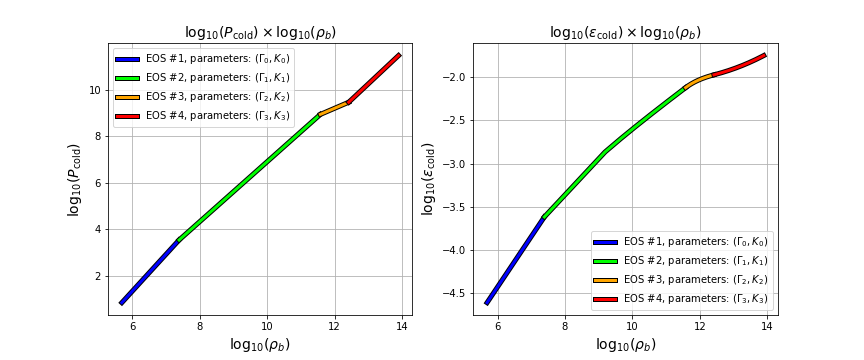

In [14]:
import TOV.Polytropic_EOSs_validation as poly_validation
# Number of equation of states
neos = 4

# User input #1: The values of rho_b that distinguish one EOS from the other
#                Values taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
rho_poly_tab = [2.44034e+07,3.78358e+11,2.62780e+12]

# User input #2: The values of Gamma to be used within each EOS
#                Values taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
Gamma_poly_tab = [1.58425,1.28733,0.62223,1.35692]

# User input #3: The value K_0, to be used within the *first* EOS. The other
#                values of K_j are determined by imposing that P be everywhere
#                continuous
#                Value taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
K_poly_tab0 = 6.80110e-09

# Set up the EOS "struct" (named tuple)
eos = poly_validation.set_up_EOS_parameters__complete_set_of_input_variables(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)

############
# PLOTTING #
############
# Step 0: Import needed Python/NRPy+ modules
import numpy as np                  # This module is used for math functions
import matplotlib.pyplot as plt     # This module is used for plotting
import matplotlib.patheffects as pe # This module is used to draw a border around our plotting curve
from IPython.display import Image   # This module is used to display saved images
# First set the number of points in the plot
n_plot = 1000

# Then split the plot by the number of EOSs used in the code
rho_b    = [0 for i in range(eos.neos)]
P_cold   = [[0 for j in range(int(n_plot/eos.neos))] for i in range(eos.neos)]
eps_cold = [[0 for j in range(int(n_plot/eos.neos))] for i in range(eos.neos)]

# Then set the plotting limits for each region
lim = [eos.rho_poly_tab[0]/50.0,eos.rho_poly_tab[0],eos.rho_poly_tab[1],eos.rho_poly_tab[2],eos.rho_poly_tab[2]*30.0]

# Then populate the rho_b arrays
for j in range(eos.neos):
    rho_b[j] = np.linspace(lim[j],lim[j+1],int(n_plot/eos.neos))

# Finally, populate the P array
for i in range(eos.neos):
    for j in range(int(n_plot/4)):
        P_cold[i][j]   = poly_validation.Polytrope_EOS__compute_P_cold_from_rhob(eos, rho_b[i][j])
        eps_cold[i][j] = poly_validation.Polytrope_EOS__compute_eps_cold_from_rhob(eos, rho_b[i][j])

# We will draw a border around our plot curve so that it
# is easier to distinguish between the EOSs. Source:
# https://stackoverflow.com/questions/12729529/can-i-give-a-border-outline-to-a-line-in-matplotlib-plot-function
colors = ['blue','lime','orange','red']
fig = plt.figure(figsize=(12,5))
nplots = 2
ax = [0 for j in range(nplots)]
ax[0] = fig.add_subplot(121)
ax[1] = fig.add_subplot(122)

titles = [r"$\log_{10}\left(P_{\rm cold}\right)\times\log_{10}\left(\rho_{b}\right)$", \
          r"$\log_{10}\left(\epsilon_{\rm cold}\right)\times\log_{10}\left(\rho_{b}\right)$"]

xlabels = [r"$\log_{10}\left(\rho_{b}\right)$", \
           r"$\log_{10}\left(\rho_{b}\right)$"]

ylabels = [r"$\log_{10}\left(P_{\rm cold}\right)$", \
           r"$\log_{10}\left(\epsilon_{\rm cold}\right)$"]
for i in range(eos.neos):
    label=r'EOS #'+str(i+1)+r', parameters: $\left(\Gamma_'+str(i)+r',K_'+str(i)+r'\right)$'
    ax[0].plot(np.log10(rho_b[i]),np.log10(P_cold[i]),label=label,c=colors[i],lw=3, path_effects=[pe.Stroke(linewidth=5,foreground='k'),pe.Normal()])
    ax[1].plot(np.log10(rho_b[i]),np.log10(eps_cold[i]),label=label,c=colors[i],lw=3, path_effects=[pe.Stroke(linewidth=5,foreground='k'),pe.Normal()])

for j in range(nplots):
    ax[j].legend()
    ax[j].grid()
    ax[j].set_title(titles[j],fontsize=14)
    ax[j].set_xlabel(xlabels[j],fontsize=14)
    ax[j].set_ylabel(ylabels[j],fontsize=14)

outfilename = "P_and_eps_cold_x_rho_b__piecewise_polytrope_neoseq4.png"
plt.savefig(outfilename)
plt.close(fig)
Image(outfilename)

<a id='pcold_plot__neoseq7'></a>

## Step 10.b: "Read et al." input set, $n_{\rm eos} = 7$ piecewise polytropic EOS \[Back to [top](#toc)\]
$$\label{pcold_plot__neoseq7}$$

Now let us generate our polytropic data from the "Read *et al.*" set of input variables, namely $\left\{\log_{10}\left(P_{4}\right),\Gamma_{4},\Gamma_{5},\Gamma_{6}\right\}$, using the values from table III in [Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf), then generate our plot.

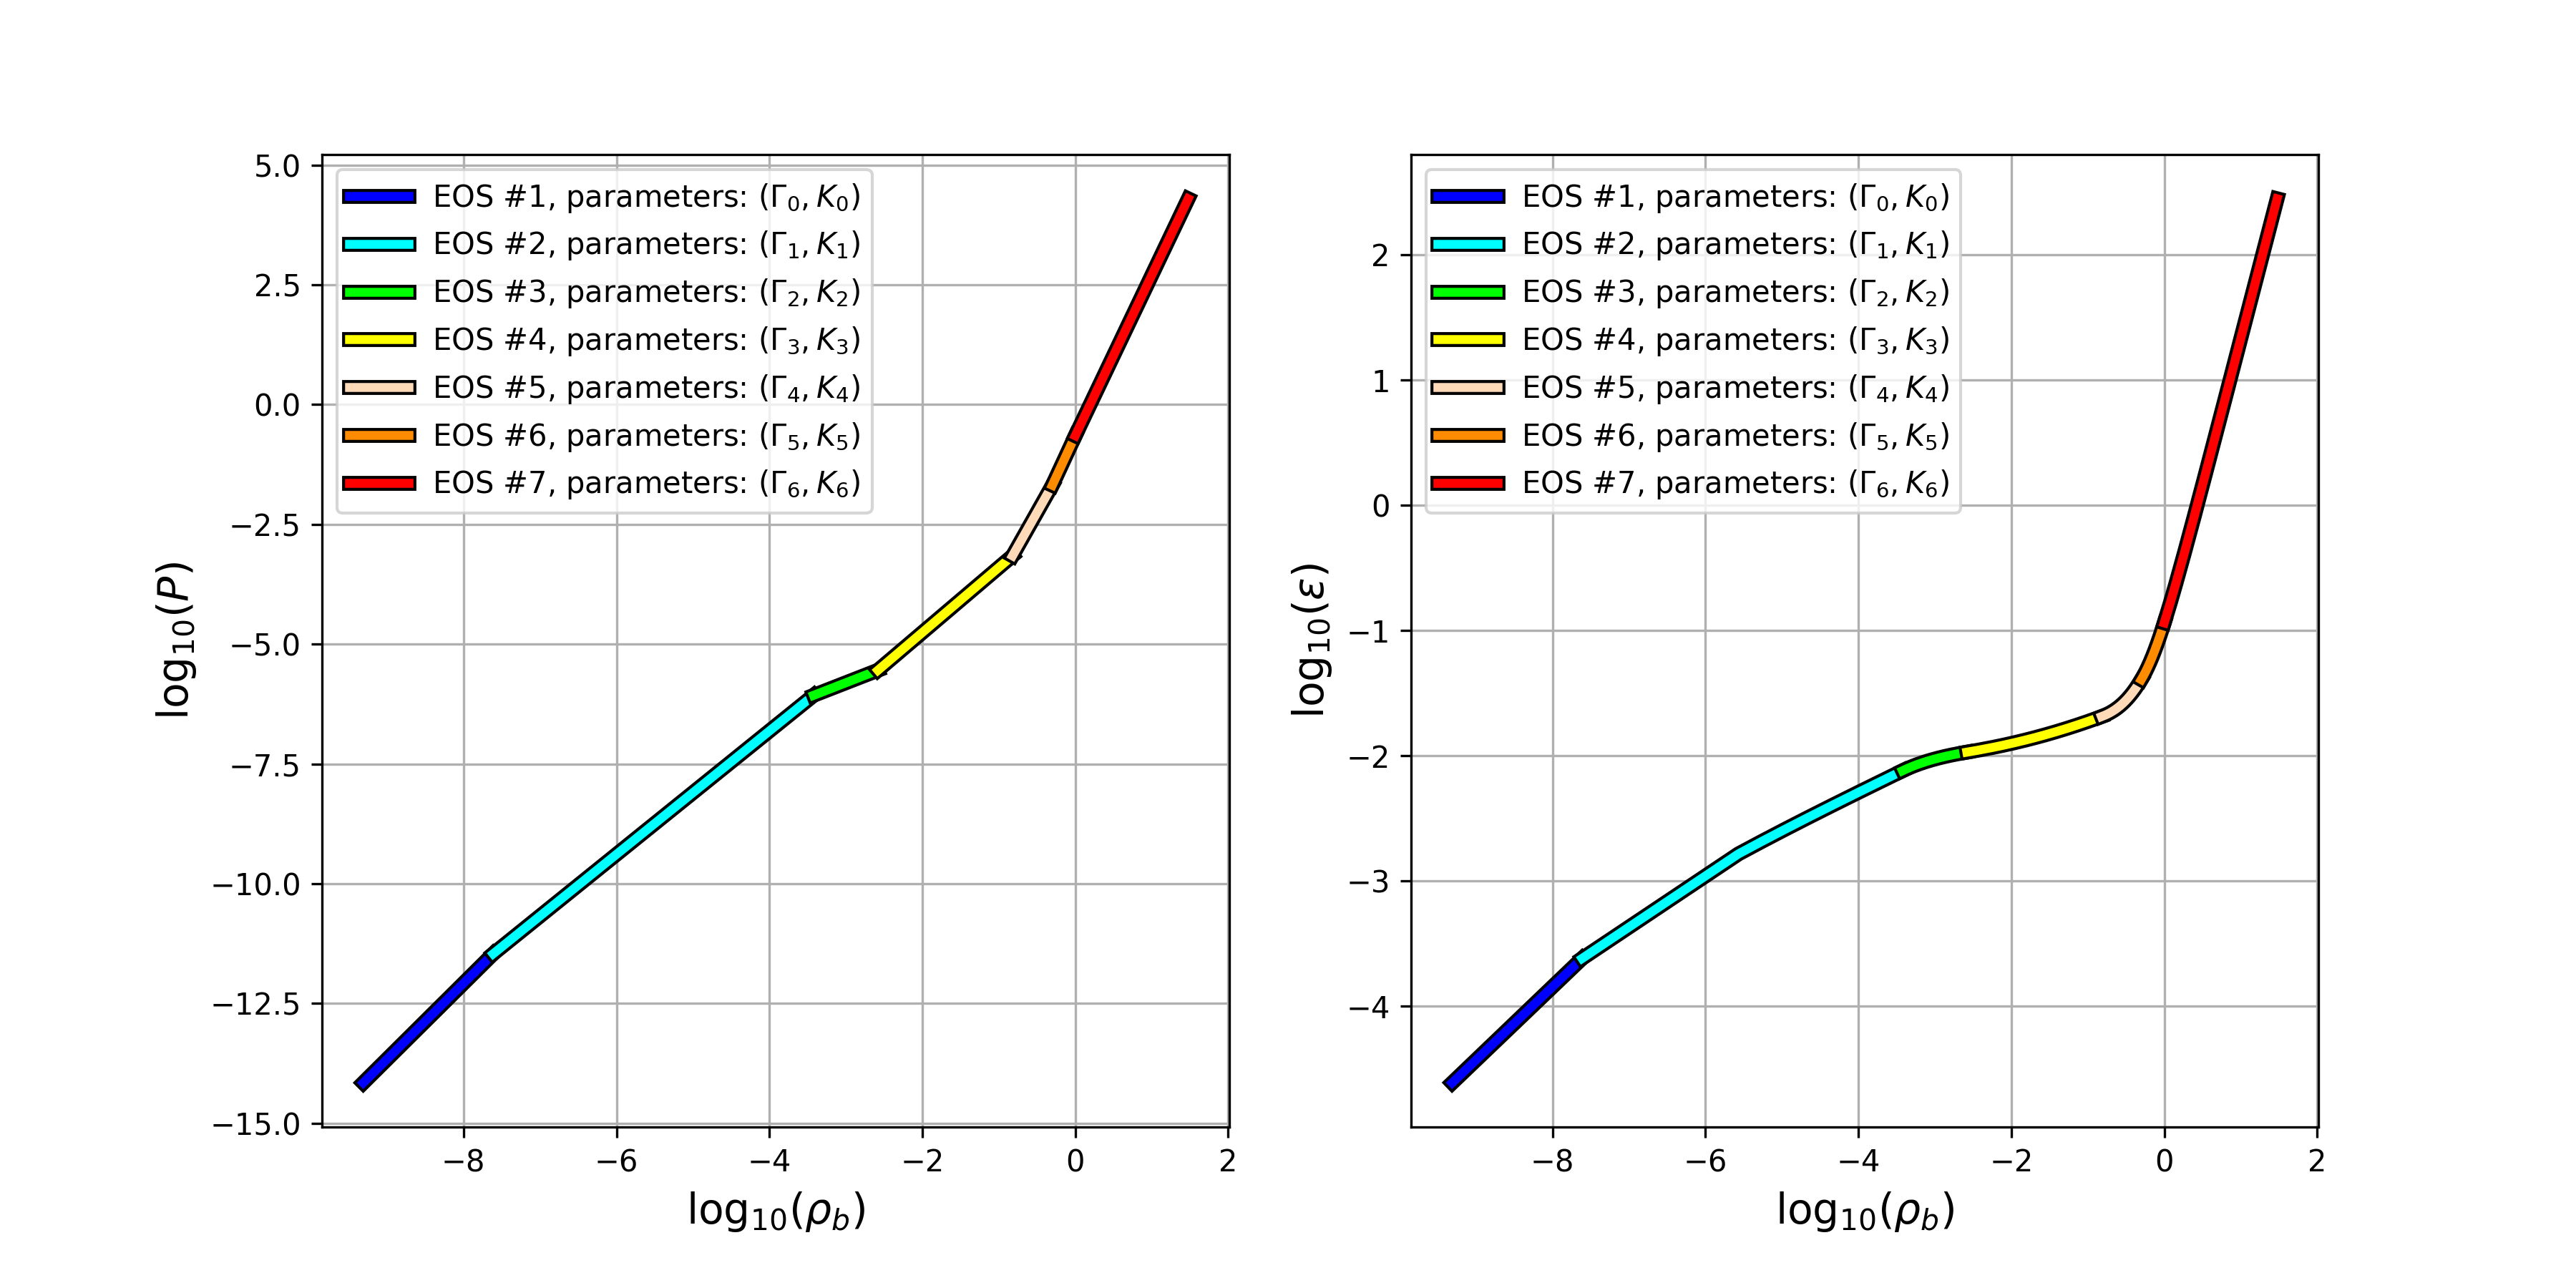

In [15]:
# Set up the EOS "struct" (named tuple)
eos = poly_validation.set_up_EOS_parameters__Read_et_al_input_variables('APR4')

############
# PLOTTING #
############
# First set the number of points in the plot
n_plot = 1000

# Then split the plot by the number of EOSs used in the code
rho_b    = [0 for i in range(eos.neos)]
P_cold   = [[0 for j in range(int(n_plot/eos.neos))] for i in range(eos.neos)]
eps_cold = [[0 for j in range(int(n_plot/eos.neos))] for i in range(eos.neos)]

# Then set the plotting limits for each region
lim = [eos.rho_poly_tab[0]/50.0,
       eos.rho_poly_tab[0],
       eos.rho_poly_tab[1],
       eos.rho_poly_tab[2],
       eos.rho_poly_tab[3],
       eos.rho_poly_tab[4],
       eos.rho_poly_tab[5],
       eos.rho_poly_tab[5]*30.0]

# Then populate the rho_b arrays
for j in range(eos.neos):
    rho_b[j] = np.linspace(lim[j],lim[j+1],int(n_plot/eos.neos))

# Finally, populate the P array
for i in range(eos.neos):
    for j in range(int(n_plot/eos.neos)):
        P_cold[i][j]   = poly_validation.Polytrope_EOS__compute_P_cold_from_rhob(eos, rho_b[i][j])
        eps_cold[i][j] = poly_validation.Polytrope_EOS__compute_eps_cold_from_rhob(eos, rho_b[i][j])

import matplotlib.pyplot as plt
# We will use the following package to draw a border around
# our plot curve so that it is easier to distinguish between
# the EOSs. Source:
# https://stackoverflow.com/questions/12729529/can-i-give-a-border-outline-to-a-line-in-matplotlib-plot-function
import matplotlib.patheffects as pe

fig = plt.figure(dpi=300,figsize=(12,6))
nplots = int(2)
ax = [0 for j in range(nplots)]
ax[0] = fig.add_subplot(121)
ax[1] = fig.add_subplot(122)

colors = ['blue','cyan','lime','yellow','peachpuff','darkorange','red']

titles = [r"$\log_{10}\left(P_{\rm cold}\right)\times\log_{10}\left(\rho_{b}\right)$", \
          r"$\log_{10}\left(\epsilon_{\rm cold}\right)\times\log_{10}\left(\rho_{b}\right)$"]

xlabels = [r"$\log_{10}\left(\rho_{b}\right)$", \
           r"$\log_{10}\left(\rho_{b}\right)$"]

ylabels = [r"$\log_{10}\left(P\right)$", \
           r"$\log_{10}\left(\epsilon\right)$"]

for i in range(eos.neos):
    label=r'EOS #'+str(i+1)+r', parameters: $\left(\Gamma_'+str(i)+r',K_'+str(i)+r'\right)$'
    ax[0].plot(np.log10(rho_b[i]),np.log10(P_cold[i]),label=label,c=colors[i],lw=3, path_effects=[pe.Stroke(linewidth=5,foreground='k'),pe.Normal()])
    ax[1].plot(np.log10(rho_b[i]),np.log10(eps_cold[i]),label=label,c=colors[i],lw=3, path_effects=[pe.Stroke(linewidth=5,foreground='k'),pe.Normal()])

for j in range(nplots):
    ax[j].legend()
    ax[j].grid()
    #ax[j].set_title(titles[j],fontsize=14)
    ax[j].set_xlabel(xlabels[j],fontsize=14)
    ax[j].set_ylabel(ylabels[j],fontsize=14)

outfilename = "P_and_eps_cold_x_rho_b__piecewise_polytrope_neoseq7.png"
plt.savefig(outfilename,dpi=300)
plt.close(fig)
Image(outfilename)

<a id='code_validation'></a>

# Step 11: Code validation \[Back to [top](#toc)\]
$$\label{code_validation}$$

We will now begin our validation tests. We will need input parameters to validate our results from this tutorial module against:
1. [Step 10.a](#code_validation__self): The [Polytropic EOSs_Python_Module](../edit/TOV/Polytropic_EOSs.py);
2. [Step 10.b](#code_validation__read_et_al): The parameter reference, [Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf);
3. [Step 10.c](#code_validation__joshua_faber_tov_solver): Results from [Joshua Faber's TOV solver](https://ccrg.rit.edu/~jfaber/BNSID/TOV/tov_solver.C);
4. [Step 10.d](#code_validation__mass_vs_radius): The neutron star's mass vs radius plots from [Demorest *et al.* (2010)](https://www.nature.com/articles/nature09466) and [Joonas Nättilä's TOV solver](https://github.com/natj/tov/blob/master/mr.pdf).

<a id='code_validation__self'></a>

## Step 11.a: Against the [TOV/Polytropic_EOSs.py](../edit/TOV/Polytropic_EOSs.py) NRPy+ module. \[Back to [top](#toc)\]
$$\label{code_validation__self}$$

We start by validating the results obtained in this tutorial module with the results obtained from the [TOV/Polytropic_EOSs.py](../edit/TOV/Polytropic_EOSs.py) NRPy+ module.

In [16]:
###################
# SELF VALIDATION #
###################
#
# Here we validate the results obtained using the function
# in this tutorial notebook with the Polytrope_EOS_Python_Module
# NRPy+ module.
#
# We start by setting up a validation function, so that we don't
# have to duplicate code while performing this validation.
import filecmp,sys
if filecmp.cmp(nrpy_module_file_path,validation_file_path):
    print("Validation: PASSED!")
else:
    print("Validation: FAILED!")
    sys.exit(1)

Validation: PASSED!


<a id='code_validation__read_et_al'></a>

## Step 11.b: Against [Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf) \[Back to [top](#toc)\]
$$\label{code_validation__read_et_al}$$

We now want to test the functions we have implemented above. In order for us to work with realistic values (i.e. values actually used by researchers), we will implement a simple test using the values from [Table II in J.C. Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf):

| $\rho_{i}$ | $\Gamma_{i}$ | $K_{\rm expected}$ |
|------------|--------------|--------------------|
|2.44034e+07 |   1.58425    |    6.80110e-09     |
|3.78358e+11 |   1.28733    |    1.06186e-06     |
|2.62780e+12 |   0.62223    |    5.32697e+01     |
|    $-$     |   1.35692    |    3.99874e-08     |

First, we have $n_{\rm eos} = 4$. Then, giving our function the values

$$
\begin{align}
\left\{\rho_{j}\right\}   &= \left\{\text{2.44034e+07},\text{3.78358e+11},\text{2.62780e+12}\right\}\ ,\\
\left\{\Gamma_{j}\right\} &= \left\{{\rm 1.58425},{\rm 1.28733},{\rm 0.62223},{\rm 1.35692}\right\}\ ,\\
K_{0} &= \text{6.80110e-09}\ ,
\end{align}
$$

we expect to obtain the values

$$
\begin{align}
K_{1} &= \text{1.06186e-06}\ ,\\
K_{2} &= \text{5.32697e+01}\ ,\\
K_{3} &= \text{3.99874e-08}\ .
\end{align}
$$

In [17]:
# Number of equation of states
neos = 4

# User input #1: The values of rho_b that distinguish one EOS from the other
#                Values taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
rho_poly_tab = [2.44034e+07,3.78358e+11,2.62780e+12]

# User input #2: The values of Gamma to be used within each EOS
#                Values taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
Gamma_poly_tab = [1.58425,1.28733,0.62223,1.35692]

# User input #3: The value K_0, to be used within the *first* EOS. The other
#                values of K_j are determined by imposing that P be everywhere
#                continuous
#                Value taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
K_poly_tab0 = 6.80110e-09

# Set up the EOS "struct" (named tuple)
import TOV.Polytropic_EOSs as poly
eos = poly.set_up_EOS_parameters__complete_set_of_input_variables(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)

# Function to compute the relative error between a and b
def rel_error(a,b):
    if a!=0:
        return np.fabs(a-b)/np.fabs(a)
    elif b!=0:
        return np.fabs(a-b)/np.fabs(b)
    else:
        return 0

# Function to compute significant digits of agreement between a and b
def significant_digits_of_agreement(a,b):
    return round(np.fabs(np.log10(np.fabs(rel_error(a,b)))))
    
# Compute significant digits of agreement between our results and
# Read et al. (2008) (https://arxiv.org/pdf/0812.2163.pdf)
Kpoly_expected = [K_poly_tab0,1.06186e-06,5.32697e+01,3.99874e-08]
for i in range(eos.neos):
    if rel_error(Kpoly_expected[i],eos.K_poly_tab[i])==0:
        print("Significant digits of agreement - Input Kpoly_%d: inf" %i)
    else:
        print("Significant digits of agreement - Input Kpoly_%d: %3d" %(i,significant_digits_of_agreement(Kpoly_expected[i],eos.K_poly_tab[i])))

Significant digits of agreement - Input Kpoly_0: inf
Significant digits of agreement - Input Kpoly_1:   5
Significant digits of agreement - Input Kpoly_2:   4
Significant digits of agreement - Input Kpoly_3:   4


<a id='code_validation__joshua_faber_tov_solver'></a>

## Step 11.c: Against [Joshua Faber's TOV solver](https://ccrg.rit.edu/~jfaber/BNSID/TOV/tov_solver.C) \[Back to [top](#toc)\]
$$\label{code_validation__joshua_faber_tov_solver}$$

<a id='code_validation__joshua_faber_tov_solver__results'></a>

### Step 11.c.i: Results from [Joshua Faber's TOV solver](https://ccrg.rit.edu/~jfaber/BNSID/TOV/tov_solver.C) \[Back to [top](#toc)\]
$$\label{code_validation__joshua_faber_tov_solver__results}$$

We now present here results obtained using [Joshua Faber's TOV solver](https://ccrg.rit.edu/~jfaber/BNSID/TOV/tov_solver.C):

| EOS Name | Central Density (g/cm$^3$) | Mass (solar masses) |      Radius (km)     | M/R (adimensional)  |
|----------|----------------------------|---------------------|----------------------|---------------------|
| **SLy**  |     $2.0\times10^{15}$     | $2.048399851801091$ | $ 9.985183794999273$ | $0.302924806758338$ |
| **APR3** |     $2.0\times10^{15}$     | $2.324551590827044$ | $10.049001815713444$ | $0.341579997979191$ |
| **APR4** |     $2.0\times10^{15}$     | $2.185879526276314$ | $ 9.770197442859468$ | $0.330368817625631$ |
| **MS1**  |     $2.0\times10^{15}$     | $2.612634529283015$ | $12.438863435136328$ | $0.310151673994438$ |
| **ALF2** |     $2.0\times10^{15}$     | $1.958593084362050$ | $10.923811531250033$ | $0.264756228030622$ |


We store these results into a dictionary, so that it is simple to compare these results with the ones obtained from NRPy+'s TOV solver.

In [18]:
# Set up a named tuple to store the TOV solution. Store:
#
# - The EOS name from Read et al. (SLy, APR1, MS1b, etc...)
# - The central density used to obtain the TOV solution
# - The value of the neutron star mass, in solar masses
# - The value of the neutron star radius, in kilometers
# - The dimensionless compactness, M/R
from collections import namedtuple  # This module is used to create named tuples
TOV_solver_results = namedtuple("TOV_Solution","EOSname rho_central M R C")

# Set up the dictionary with the results of
# asorted EOSs obtained using Faber's TOV solver:
# https://ccrg.rit.edu/~jfaber/BNSID/TOV/tov_solver.C
rho_central = 2.0e15
Faber_TOV_solver_dict = {}
Faber_TOV_solver_dict["SLy"]  = (TOV_solver_results("SLy" ,rho_central,2.048399851801091, 9.985183794999273,0.302924806758338))
Faber_TOV_solver_dict["APR3"] = (TOV_solver_results("APR3",rho_central,2.324551590827044,10.049001815713444,0.341579997979191))
Faber_TOV_solver_dict["APR4"] = (TOV_solver_results("APR4",rho_central,2.185879526276314, 9.770197442859468,0.330368817625631))
Faber_TOV_solver_dict["MS1"]  = (TOV_solver_results("MS1" ,rho_central,2.612634529283015,12.438863435136328,0.310151673994438))
Faber_TOV_solver_dict["ALF2"] = (TOV_solver_results("ALF2",rho_central,1.958593084362050,10.923811531250033,0.264756228030622))

<a id='code_validation__joshua_faber_tov_solver__restoring_units'></a>

### Step 11.c.ii: Restoring units to the solution of NRPy+'s TOV solver \[Back to [top](#toc)\]
$$\label{code_validation__joshua_faber_tov_solver__restoring_units}$$

It is important to note, however, that while Faber outputs the Neutron star's (NS) mass in solar masses and its radius in kilometers, our code outputs them in geometrized units where $G=1=c$. Thus, we must restore units to our results before we are able to compare the results.

Our code is written in such a way that

$$
1 \text{ in code units} \leftrightarrow 1\times10^{15}\,{\rm g/cm^{3}}\ ,
$$

so that, because $G=1=c$, $\rho$ has units of inverse length squared (i.e. $\rm cm^{-2}$), while $M$ and $R$ both have units of length (i.e $\rm cm$). Thus, to restore units, we reintroduce (in cgs units)

\begin{align}
G &= 6.67408\times10^{-8}\,\frac{\rm cm^{3}}{\rm g\cdot s^{2}}\ ,\\
c &= 2.99792\times10^{10}\,\frac{\rm cm}{\rm s}\ ,
\end{align}

and the mass of the Sun

\begin{align}
M_{\odot} = 1.989\times10^{33}\,{\rm g}\ .
\end{align}

Consider the notation $\left[A\right]$ to represent the *units* of the quantity $A$. In other words,

\begin{align}
\left[G\right] &= \frac{\rm cm^{3}}{\rm g\cdot s^{2}}\ ,\\
\left[c\right] &=\frac{\rm cm}{\rm s}\ ,\\
\left[M_{\odot}\right] &= {\rm g}\ .
\end{align}

Then, to restore the units of $M$, which currently has units of length, we need to find a combination of $G$ and $c$ that will convert that to units of mass again. Consider

$$
\left[\frac{G}{c^{2}}\right]
= \left(\frac{\rm cm^{3}}{\rm g\cdot s^{2}}\right)\left(\frac{\rm cm}{\rm s}\right)^{-2}
= \left(\frac{\rm cm^{3}}{\rm g\cdot s^{2}}\right)\left(\frac{\rm s^{2}}{\rm cm^{2}}\right)
= \frac{\rm cm}{\rm g}\ .
$$

Thus, to convert our code's mass to grams, we have

$$
\boxed{M_{\rm grams} = \left(\frac{c^{2}}{G}\right)M_{\rm code\ units}}\ .
$$

To obtain the mass of the NS in solar masses we simply divide the NS mass by the mass of the Sun

$$
\boxed{M_{\rm solar\ masses} = \frac{M_{\rm grams}}{M_{\odot}}}\ .
$$

To obtain our basic unit of length, we first notice that one code unit can be converted to $\rm cm^{2}$ by doing

$$
\left(1\text{ in code units}\right)\times\left(\frac{G}{c^{2}}\right) = \left(\frac{G}{c^{2}}\right)\times10^{15}\,{\rm cm^{-2}}\ .
$$

Thus we can obtain the relation

$$
\left[\left(1\text{ in code units}\right)\times\left(\frac{G}{c^{2}}\right)\right]^{-1/2} = \sqrt{\left(\frac{c^{2}}{G}\right)\times10^{-15}}\,{\rm cm}\ .
$$

Finally, we can convert $R_{\rm code\ units}$ to kilometers by considering $1\,{\rm cm} = 1\times10^{-5}\,{\rm km}$, which yields

$$
\boxed{R_{\rm km} = \left[10^{-5}\sqrt{\left(\frac{c^{2}}{G}\right)\times10^{-15}}\right]R_{\rm code\ units}}\ .
$$

In [19]:
# Unit conversion: From our code's units to dimensionful quantities
#
# Set basic physical constants
def convert_M_to_solar_masses_and_R_to_km(M,R):
    Msun = 1.98900e+33 # g                    # Mass of the sun                 
    c    = 2.99792e+10 # cm s^(-1)            # Speed of light
    G    = 6.67408e-08 # cm^(3) g^(-1) s^(-2) # Gravitational constant

    # Set our code's units
    one_code_unit_in_one_over_cm2 = 1.0e+15 * G / c**2
    one_code_unit_in_cm = 1.0/one_code_unit_in_one_over_cm2**0.5
    one_code_unit_in_km = one_code_unit_in_cm*1e-5

    # Convert R and M to numpy arrays, so that we can
    # manipulate all entries with a single line of code
    M = np.array(M)
    R = np.array(R)

    # Convert mass to solar masses
    M_in_g = M * one_code_unit_in_cm * c**2/G
    M_in_solar_masses = M_in_g/Msun

    # Convert code radius to km
    R_in_km = R*one_code_unit_in_km
    
    return M_in_solar_masses, R_in_km

<a id='code_validation__joshua_faber_tov_solver__validation'></a>

### Step 11.c.iii: Validation of NRPy+'s results \[Back to [top](#toc)\]
$$\label{code_validation__joshua_faber_tov_solver__validation}$$

Finally, we use [NRPy+'s TOV solver](../edit/TOV/TOV_solver.py) \[[**Tutorial**](Tutorial-ADM_Initial_Data-TOV.ipynb)\] to obtain solutions to the same EOSs we have used in Josh Faber's TOV solver. We then show the relative errors between our solutions and Faber's.

In [20]:
# Load the NRPy+ TOV solver module
import TOV.TOV_Solver as TOV

# Set up the central density
rho_central = 2.0

# Set up which EOSs we want to solve for
EOSnames = ["SLy","APR3","APR4","MS1","ALF2"]

# Initialize the dictionary of NRPy+ TOV solutions
NRPy_TOV_solver_dict = {}

# Populate the dictionary
for EOSname in EOSnames:
    # Set up the EOS based on the EOSname
    eos = poly.set_up_EOS_parameters__Read_et_al_input_variables(EOSname)
    
    # Compute the mass and radius of the NS for the given EOS and central density
    Mass, RadiusSchw, Radius_iso = TOV.TOV_Solver(eos,rho_baryon_central=rho_central,verbose=False,return_M_RSchw_and_Riso=True,accuracy="medium",no_output_File=True)
    
    # Convert the mass and radius to the same units as Josh's code
    M,RSchw = convert_M_to_solar_masses_and_R_to_km(Mass, RadiusSchw)
    
    # Add the solution to our dictionary
    NRPy_TOV_solver_dict[EOSname] = (TOV_solver_results(EOSname ,rho_central,M,RSchw,Mass/RadiusSchw))
    print("Found M and R for the EOS: "+EOSname)

# Print with colors
# Reference #1: https://stackoverflow.com/questions/16816013/is-it-possible-to-print-using-different-colors-in-ipythons-notebook
# Reference #2: https://en.wikipedia.org/wiki/ANSI_escape_code
def print_red(text):
    return "\x1b[38;5;160m"+text+"\x1b[0m"

def print_blue(text):
    return "\x1b[38;5;20m"+text+"\x1b[0m"

# Print out significant digits of agreement between Josh's and
# NRPy+'s solutions, for the mass, radius, and compactness of
# the Neutron stars obtained using different PPEOSs
print(".---------------------------------.----------.------------.-----------------.")
for EOSname in NRPy_TOV_solver_dict:
    if len(EOSname)==4:
        print("|   Validation of the EOS: "+print_blue(EOSname)+"   |----------|------------|-----------------|")
    elif len(EOSname)==3:
        print("|   Validation of the EOS: "+print_blue(EOSname)+"    |----------|------------|-----------------|")
    sig_digits_M = significant_digits_of_agreement(NRPy_TOV_solver_dict[EOSname].M,Faber_TOV_solver_dict[EOSname].M)
    sig_digits_R = significant_digits_of_agreement(NRPy_TOV_solver_dict[EOSname].R,Faber_TOV_solver_dict[EOSname].R)
    sig_digits_C = significant_digits_of_agreement(NRPy_TOV_solver_dict[EOSname].C,Faber_TOV_solver_dict[EOSname].C)
    print("| "+print_red("Significant digits of agreement")+" | Mass = %d | Radius = %d | Compactness = %d |" %(sig_digits_M,sig_digits_R,sig_digits_C))
    print(".---------------------------------.----------.------------.-----------------.")

Found M and R for the EOS: SLy
Found M and R for the EOS: APR3
Found M and R for the EOS: APR4
Found M and R for the EOS: MS1
Found M and R for the EOS: ALF2
.---------------------------------.----------.------------.-----------------.
|   Validation of the EOS: SLy    |----------|------------|-----------------|
| Significant digits of agreement | Mass = 4 | Radius = 5 | Compactness = 6 |
.---------------------------------.----------.------------.-----------------.
|   Validation of the EOS: APR3   |----------|------------|-----------------|
| Significant digits of agreement | Mass = 4 | Radius = 5 | Compactness = 6 |
.---------------------------------.----------.------------.-----------------.
|   Validation of the EOS: APR4   |----------|------------|-----------------|
| Significant digits of agreement | Mass = 4 | Radius = 5 | Compactness = 6 |
.---------------------------------.----------.------------.-----------------.
|   Validation of the EOS: MS1    |----------|------------|---

<a id='code_validation__mass_vs_radius'></a>

## Step 11.d: Mass vs. Radius relations \[Back to [top](#toc)\]
$$\label{code_validation__mass_vs_radius}$$

We now subject our functions to a very stringent test, where we aim to determine the relationship between the mass and radius of Neutron stars subject to different piecewise polytropic EOS parameters.

A similar, yet more complete, plot to the one we are generating is [Figure 3 in Demorest *et al.* (2010)](https://www.nature.com/articles/nature09466) (notice that the figure can be accessed by going into the "Figure" tab on the right).

Another plot which is identical to ours can be found by looking at the results of [Joonas Nättilä's TOV solver](https://github.com/natj/tov/blob/master/mr.pdf).

Let us start by defining a simple loop that computes a set of pairs $\left\{M,R\right\}$ for different values of $\rho_{\rm central}$.

In [21]:
import TOV.TOV_Solver as TOV

def M_of_R(EOSname,rho_central=3e-1,factor=1.1,max_iterations=300,accuracy="verylow",integrator_type="default"):
    
    M = []
    R = []
    eos = poly.set_up_EOS_parameters__Read_et_al_input_variables(EOSname)
    Mass_TOV, RSchw_TOV, Riso_TOV = TOV.TOV_Solver(eos,rho_baryon_central=rho_central,verbose=False,return_M_RSchw_and_Riso=True,no_output_File=True)
    M.append(Mass_TOV)
    R.append(RSchw_TOV)
    rho_central *= factor

    for j in range(1,max_iterations):
        Mass_TOV, RSchw_TOV, Riso_TOV = TOV.TOV_Solver(eos,rho_baryon_central=rho_central,verbose=False,return_M_RSchw_and_Riso=True,accuracy=accuracy,integrator_type=integrator_type,no_output_File=True)
        if(Mass_TOV >= M[j-1]):
            M.append(Mass_TOV)
            R.append(RSchw_TOV)
            rho_central *= factor
            
        else:
            # This snippet is just meant to make all EOS names
            # have length = max_EOS_length. This is just for
            # cosmetic purposes on our print statements.
            max_EOSname_length = 4
            if len(EOSname) == max_EOSname_length:
                pass
            else:
                for i in range(max_EOSname_length - len(EOSname)):
                    EOSname += " "

            print(EOSname+": DONE after "+str(j)+" iterations!")
            break
            
    M, R = convert_M_to_solar_masses_and_R_to_km(M,R)
    return M, R

Then we compute different sets of pairs $\left\{M,R\right\}$ for different EOSs, as given by table III in [Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf)

In [22]:
import time
# Generate the plot data
# Warning: This low resolution setting should take between
#          220 and 280 seconds to run.
#          For a higher resolution plot, change the factor
#          value from 1.10 to 1.03. Keep in mind that this
#          will slow down the code even further.
start = time.time()
factor = 1.10
max_it = 300
M_WFF1, R_WFF1 = M_of_R("WFF1",rho_central=3.5e-1,factor=factor,max_iterations=max_it)
M_WFF2, R_WFF2 = M_of_R("WFF2",rho_central=3.0e-1,factor=factor,max_iterations=max_it)
M_APR3, R_APR3 = M_of_R("APR3",rho_central=3.0e-1,factor=factor,max_iterations=max_it)
M_APR4, R_APR4 = M_of_R("APR4",rho_central=3.0e-1,factor=factor,max_iterations=max_it)
M_SLy,  R_SLy  = M_of_R("SLy" ,rho_central=2.7e-1,factor=factor,max_iterations=max_it)
M_ENG,  R_ENG  = M_of_R("ENG" ,rho_central=2.7e-1,factor=factor,max_iterations=max_it)
M_H4,   R_H4   = M_of_R("H4"  ,rho_central=1.9e-1,factor=factor,max_iterations=max_it)
M_ALF2, R_ALF2 = M_of_R("ALF2",rho_central=2.7e-1,factor=factor,max_iterations=max_it)
M_MS1,  R_MS1  = M_of_R("MS1" ,rho_central=2.1e-1,factor=factor,max_iterations=max_it)
M_MS1b, R_MS1b = M_of_R("MS1b",rho_central=2.1e-1,factor=factor,max_iterations=max_it)
M_MPA1, R_MPA1 = M_of_R("MPA1",rho_central=2.1e-1,factor=factor,max_iterations=max_it)
end = time.time()
print("Finished generating plot data. Time elapsed: %.2lf seconds."%(end-start))

WFF1: DONE after 20 iterations!
WFF2: DONE after 21 iterations!
APR3: DONE after 19 iterations!
APR4: DONE after 20 iterations!
SLy : DONE after 22 iterations!
ENG : DONE after 21 iterations!
H4  : DONE after 23 iterations!
ALF2: DONE after 20 iterations!
MS1 : DONE after 19 iterations!
MS1b: DONE after 19 iterations!
MPA1: DONE after 22 iterations!
Finished generating plot data. Time elapsed: 40.64 seconds.


Finally, we generate the plot.

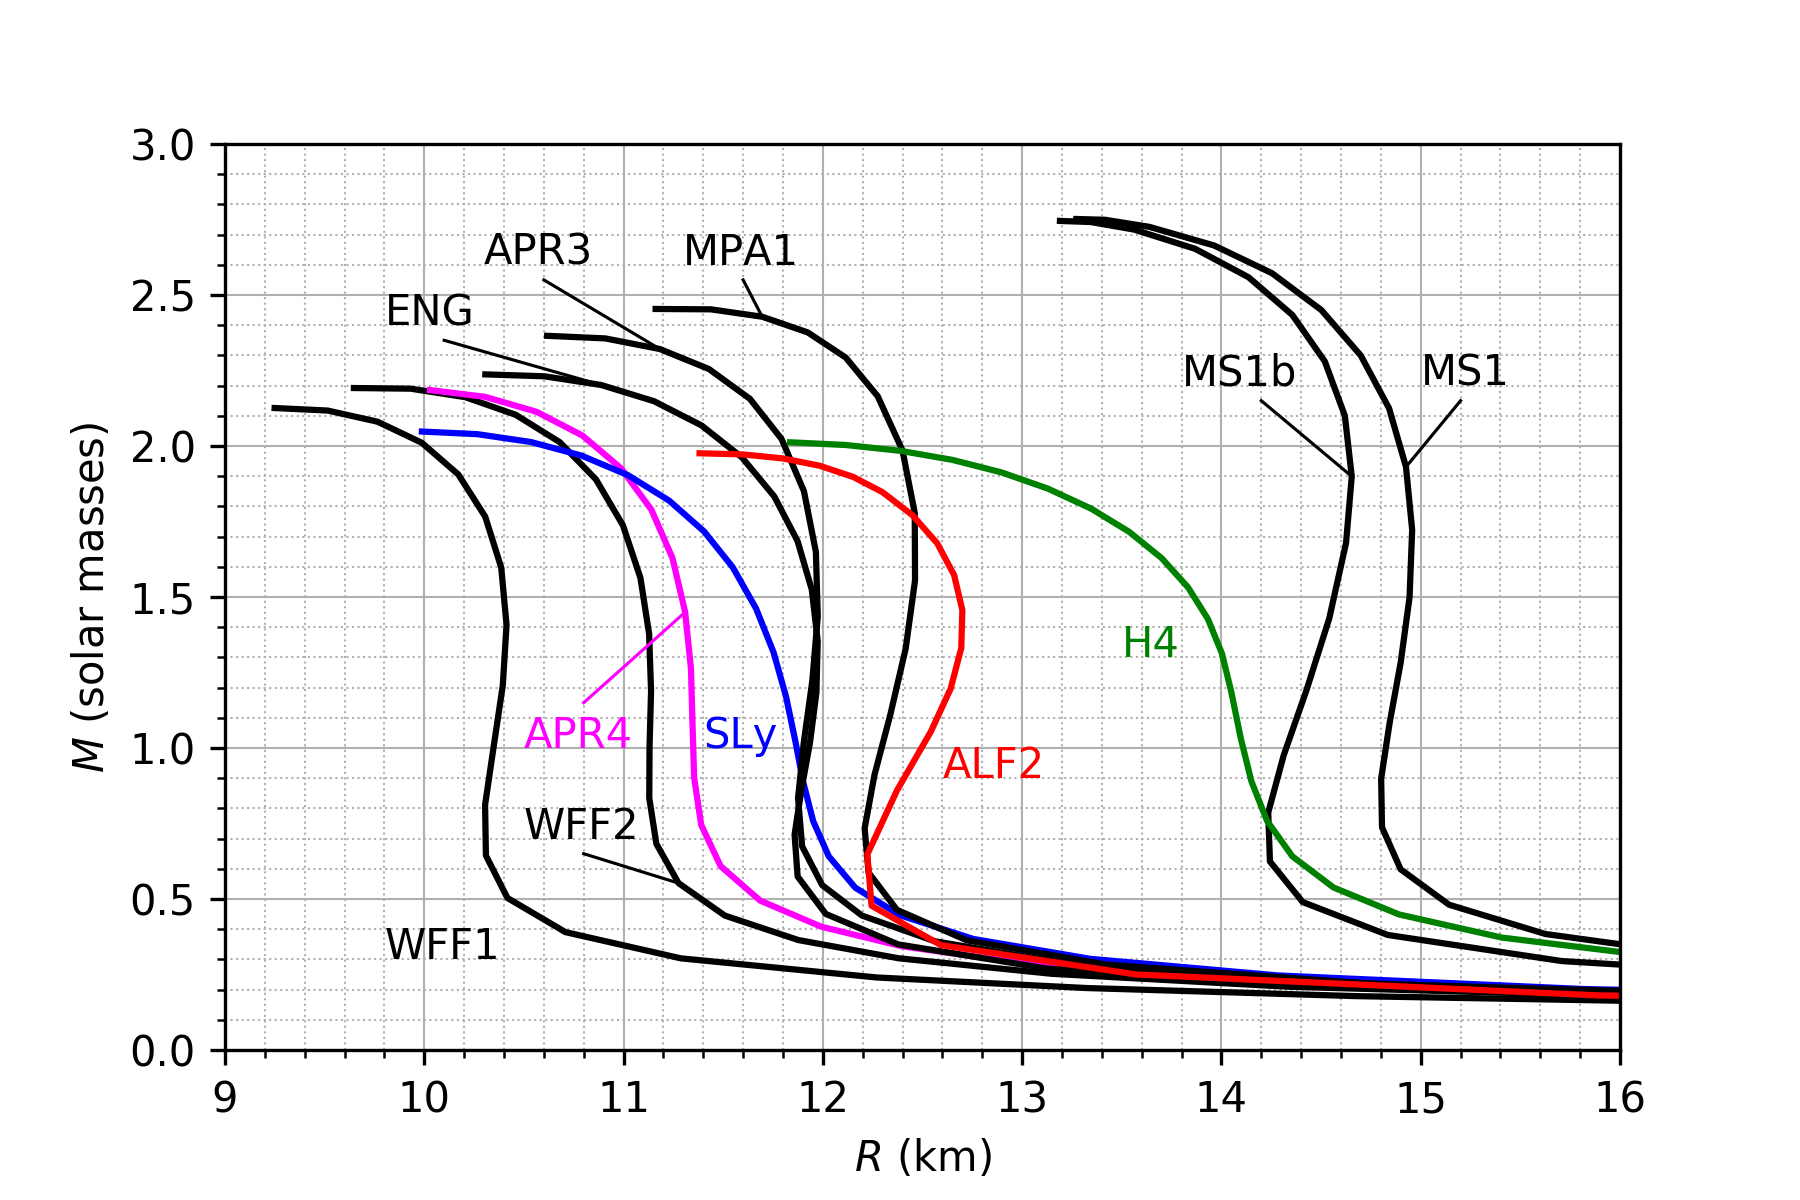

In [23]:
# Plotting different PPEOS Mass vs Radius relations
#
# Set up basic plot parameters
fig = plt.figure(dpi=300)
# plt.title(r"Piecewise Polytrope EOS $-$ Mass vs Radius")
plt.xlabel(r"$R$ (km)")
plt.ylabel(r"$M$ (solar masses)")
plt.xlim(9,16)
plt.ylim(0,3)
plt.minorticks_on()
plt.grid(which='major',lw=0.5)
plt.grid(which='minor',ls=":",lw=0.5)

# Plot the WFF1 EOS and its legend
color = 'k'
plt.plot(R_WFF1,M_WFF1,color=color)
plt.text(9.8,0.3,"WFF1",color=color)

# Plot the WFF2 EOS and its legend
plt.plot(R_WFF2,M_WFF2,'k')
plt.text(10.5,0.7,"WFF2",color='k')
plt_pt = int(np.ceil(0.3*len(R_WFF2)))
plt.plot(np.linspace(10.8,R_WFF2[plt_pt],10),np.linspace(0.65,M_WFF2[plt_pt],10),'k',lw=0.75)

# Plot the APR4 EOS and its legend
plt.plot(R_APR4,M_APR4,'magenta')
plt.text(10.5,1,"APR4",color='magenta')
plt_pt = int(np.ceil(0.6*len(R_APR4)))
plt.plot(np.linspace(10.8,R_APR4[plt_pt],10),np.linspace(1.15,M_APR4[plt_pt],10),'magenta',lw=0.75)

# Plot the SLy EOS and its legend
plt.plot(R_SLy ,M_SLy,'b')
plt.text(11.4,1,"SLy",color='b')

# Plot the ENG EOS and its legend
plt.plot(R_ENG ,M_ENG,color='k')
plt.text(9.8,2.4,"ENG",color='k')
plt_pt = int(np.ceil(0.85*len(R_ENG)))
plt.plot(np.linspace(10.1,R_ENG[plt_pt],10),np.linspace(2.35,M_ENG[plt_pt],10),'k',lw=0.75)

# Plot the APR3 EOS and its legend
plt.plot(R_APR3,M_APR3,color='k')
plt.text(10.3,2.6,"APR3",color='k')
plt_pt = int(np.ceil(0.8*len(R_APR3)))
plt.plot(np.linspace(10.6,R_APR3[plt_pt],10),np.linspace(2.55,M_APR3[plt_pt],10),'k',lw=0.75)

# Plot the MPA1 EOS and its legend
plt.plot(R_MPA1,M_MPA1,color='k')
plt.text(11.3,2.6,"MPA1",color='k')
plt_pt = int(np.ceil(0.85*len(R_MPA1)))
plt.plot(np.linspace(11.6,R_MPA1[plt_pt],10),np.linspace(2.55,M_MPA1[plt_pt],10),'k',lw=0.75)

# Plot the AFL2 EOS and its legend
plt.plot(R_ALF2,M_ALF2,color='r')
plt.text(12.6,0.9,"ALF2",color='r')

# Plot the MS1b EOS and its legend
plt.plot(R_MS1b,M_MS1b,color='k')
plt.text(13.8,2.2,"MS1b",color='k')
plt_pt = int(np.ceil(0.5*len(R_MS1b)))
plt.plot(np.linspace(14.2,R_MS1b[plt_pt],10),np.linspace(2.15,M_MS1b[plt_pt],10),'k',lw=0.75)

# Plot the H4 EOS and its legend
plt.plot(R_H4  ,M_H4,color='g')
plt.text(13.5,1.3,"H4",color='g')

# Plot the MS1 EOS and its legend
plt.plot(R_MS1 ,M_MS1,color='k')
plt.text(15,2.2,"MS1",color='k')
plt_pt = int(np.ceil(0.5*len(R_MS1)))
plt.plot(np.linspace(15.2,R_MS1[plt_pt],10),np.linspace(2.15,M_MS1[plt_pt],10),'k',lw=0.75)

# Save the plot as a PNG picture
filename = "piecewise_polytrope__MvsR.png"
plt.savefig(filename)

# Close the plot and import the image for display
plt.close(fig)
Image(filename)

<a id='latex_pdf_output'></a>

# Step 12: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-TOV-Piecewise_Polytrope_EOSs](Tutorial-TOV-Piecewise_Polytrope_EOSs.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [24]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx --log-level='WARN' Tutorial-TOV-Piecewise_Polytrope_EOSs.ipynb
!pdflatex -interaction=batchmode Tutorial-TOV-Piecewise_Polytrope_EOSs.tex
!pdflatex -interaction=batchmode Tutorial-TOV-Piecewise_Polytrope_EOSs.tex
!pdflatex -interaction=batchmode Tutorial-TOV-Piecewise_Polytrope_EOSs.tex
!rm -f Tut*.out Tut*.aux Tut*.log

This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
